In [3]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
from scipy import special
from random import gauss
#import hdf5storage
import h5py
import timeit
from numba import jit
#from sympy.solvers.solveset import nonlinsolve
#from sympy.core.symbol import symbols
#from sympy import exp
from scipy import stats
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.analysis import *
from core.simulation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


####################################################################################################### 
#(convert to cell and run only if needed) 
#Obtain 1-normalized laplacian eigenvalues & eigenvectors from Selen's data and save them to file

f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
Adjacency = sparse.csc_matrix( (f['combined']['A']['data'], f['combined']['A']['ir'], f['combined']['A']['jc']) ).toarray()
CC = np.asarray(f['CC']['restInds'], dtype=int)
#Laplacian = sparse.csc_matrix( (f['combined']['L']['data'], f['combined']['L']['ir'], f['combined']['L']['jc']) ).toarray()
#Degree = sparse.csc_matrix( (f['combined']['DegreeM']['data'], f['combined']['DegreeM']['ir'], f['combined']['DegreeM']['jc']) ).toarray()
f.close()
indices = np.array([elem[0] for elem in CC])-1
Adjacency = Adjacency[indices,:]
Adjacency = Adjacency[:,indices]
Deg=np.sum(Adjacency, axis=0)
sqrt_Deg=np.power(Deg,-0.5)
Degree_Matrix=sp.sparse.diags(Deg)
sqrt_Degree_Matrix=sp.sparse.diags(sqrt_Deg)
regLap = Degree_Matrix - sp.sparse.csc_matrix(Adjacency)
Laplacian = (sp.sparse.csc_matrix.dot(sqrt_Degree_Matrix,sp.sparse.csc_matrix.dot(regLap,sqrt_Degree_Matrix))).toarray()
Laplacian[Laplacian>1]=1

eigenvalues2, eigenvectors2 = np.linalg.eigh(Laplacian)
#eigenvectors2 matrix: each COLUMN eigenvectors2[:,i] is a normalized eigenvector

#do we want to set the first eigenvalues to the known value, which should be zero?
#eigenvalues2[0] = 0
#1-norm normalization
for col in range(eigenvectors2.shape[1]):
    eigenvectors2[:,col]/=np.sum(eigenvectors2[:,col])


#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals.npy', eigenvalues2)
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy', eigenvectors2)


In [5]:
#If known, read eigenvalues and eigenvectors from file
eigenvalues2 = np.load('../data/eigvals.npy')
#eigenvectors2 = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy')

In [6]:
#Set parameters and bounds for minimization algorithms
aEE, bnds_aEE = 30, (0.01,500)
aIE, bnds_aIE = 20, (0.01,500)
aEI, bnds_aEI = 150, (0.01,500)
aII, bnds_aII = 15, (0.01,500)
dE, bnds_dE = 5, (0.01,20)
dI, bnds_dI = 5, (0.01,20)
P, bnds_P = 1, (0,10)
Q, bnds_Q = 0, (0,10)
sEE, bnds_sEE = 30, (0,500)
sIE, bnds_sIE = 45, (0,500)
sEI, bnds_sEI = 169, (0,500)
sII, bnds_sII = 60, (0,500)
D, bnds_D = 1, (0.1,10)             #unchanged
tE, bnds_tE = 1, (0.01,10)          #unchanged
tI, bnds_tI = 1, (0.01,10)          #unchanged
#snE, bnds_snE = 1, (1,10)        #unchanged
#snI, bnds_snI = 1, (1,10)         #unchanged

initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,D,tE,tI])#,snE])#,snI]) 
bnds=[bnds_aEE,bnds_aIE,bnds_aEI,bnds_aII,bnds_dE,bnds_dI,bnds_P,bnds_Q,bnds_sEE,bnds_sIE,bnds_sEI,bnds_sII,bnds_D,bnds_tE,bnds_tI]#,bnds_snE]#,bnds_snI]

Graph_Kernel='Gaussian'
first_k=2
True_Spectrum = 15*(np.arange(first_k,5000)**(-0.3))
LSA=True
Visual=False
SaveFiles=False
FilePath=' '

Args = (eigenvalues2, Graph_Kernel, True_Spectrum, first_k, LSA, Visual, SaveFiles)

E*=0.0250, I*=0.1713: stable, with nonzero imaginary components
E*=0.1511, I*=0.2068: unstable
E*=0.1719, I*=0.2068: strictly stable
Best suitable steady state: 2, with Ess=0.1719 Iss=0.2068, Distance: 10.9575, Scale: 9.3639


<IPython.core.display.Javascript object>


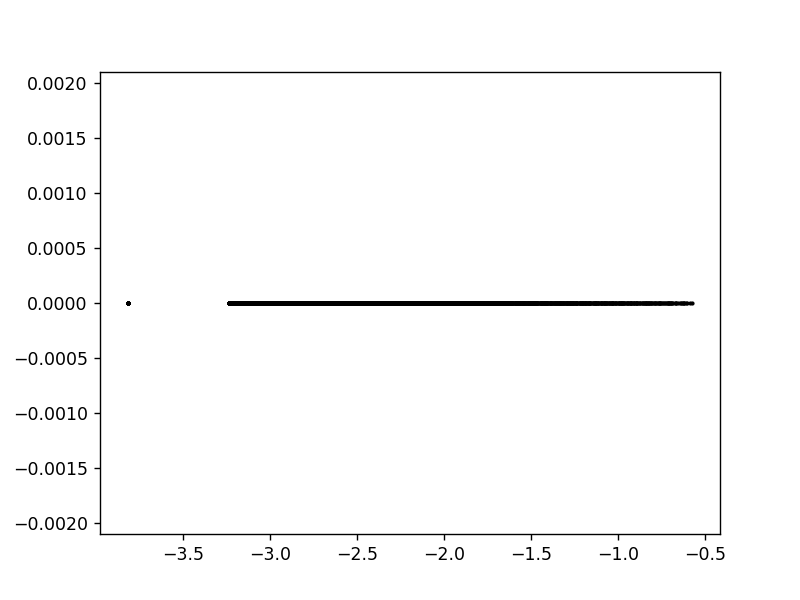

<IPython.core.display.Javascript object>


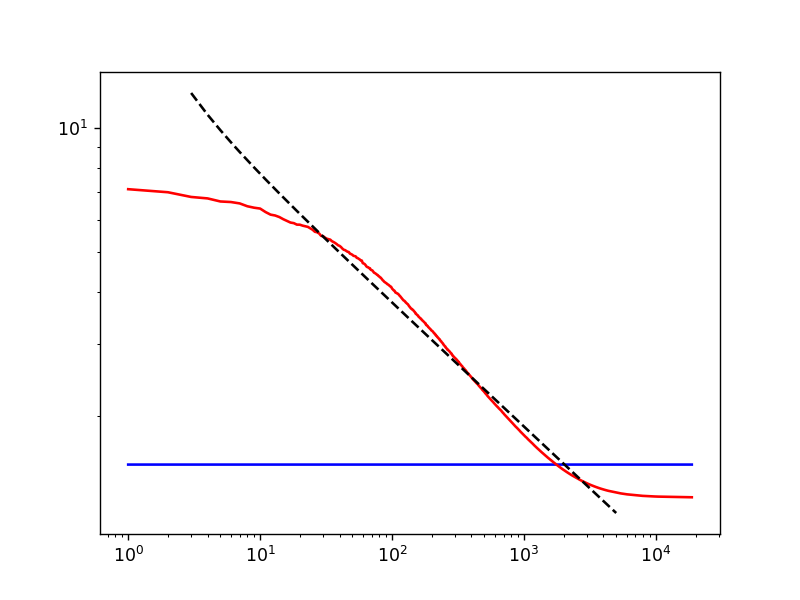

10.957459256442649

In [7]:
############################
#single analysis for easy visualization (note that if there are multiple stedy states the visualization will refer to the best one)
better_result=dict(x=np.array([ 29.77529941,  21.06331709, 150.55575927,  14.99903785,
         4.88310371,   4.83602554,   0.89113403,   0.3746431 ,
         9.37986292,  44.64844318, 168.74697677,  60.24053228,
         9.91505435,   1.508338  ,   1.26766455]))


Full_Analysis(better_result['x'], eigenvalues2, Graph_Kernel, True_Spectrum, first_k, LSA, True, SaveFiles, FilePath)

In [ ]:
############################
#simple attempt at power spectrum fitting with a minimization algorithm. May get stuck in local minima.
#playing around with tolerance and max number of iterations is often necessary, depending on initial conditions. e.g.
#First run with fairly random initial guess: tol=1e-03, no maxiter (will take a while)
#Run starting from a previously obtained result: tol=1e-08, 'maxiter':2000

#initial_guess=better_result['x']
result = sp.optimize.minimize(Full_Analysis, initial_guess, args=Args,
                              method='Nelder-Mead',#'L-BFGS-B', 
                              bounds=bnds, 
                              tol=1e-08)
                             # options={'maxiter':2000})

In [10]:
############################
#more complicated fitting attempt with basinhopping stochastic minimization
#to obtain good results in sensible amounts of time, playing with minimization parameters is required
#the relevant parameter are again tolerance and maxiter, similarly to above (which affect the local minimization loop)
#but also niter and stepsize. these specify how many local minimizations we wish to carry out, 
#and the size of the basin-hopping random step inbetween local minimizations

#better_result=dict(x=np.array([ 29.77529941,  21.06331709, 150.55575927,  14.99903785,
#         4.88310371,   4.83602554,   0.89113403,   0.3746431 ,
#         9.37986292,  44.64844318, 168.74697677,  60.24053228,
#         9.91505435,   1.508338  ,   1.26766455,   4.38755284,
#         1.31683817]))

#new_initial_guess=better_result['x']
new_initial_guess=initial_guess

#sort of ugly, but need to defind bounds manually for basinhopping
class MyBounds(object):
    def __init__(self, xmax=[elem[1] for elem in bnds], xmin=[elem[0] for elem in bnds] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        t=tmax and tmin
        
        Steady_States, Success = H_Simple_Steady_State(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])
        #print(t and Success)
        return t and Success
    #potential TODO: only accept parameter sets that return stable positive steady states (actually no: they might be locally near a suitable state. still worth to do local minimization)

mybounds = MyBounds()

#minimizer_kwargs={'args':Args, 'method':'TNC', 'bounds':bnds, 'tol':1e-03, 'options':{'maxiter':500}}


def custom_min(fun, x0, args, **kwargs):
    Bounds=bnds
    Bounds[0:8]=[(elem,elem) for elem in x0[0:8]]
     
    return sp.optimize.minimize(fun,x0,args=Args, method='Nelder-Mead',# bounds=Bounds,
                                tol=1e-06,
                                options={'maxiter':800})


better_result = sp.optimize.basinhopping(Full_Analysis, new_initial_guess, niter=200, stepsize=1,
                                  minimizer_kwargs=dict(method=custom_min),
                                  accept_test=MyBounds())

#initial_guess=better_result['x']

E*=0.1859, I*=0.2: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.186 Iss=0.2, Distance: 714.474
E*=0.1905, I*=0.2: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.191 Iss=0.2, Distance: 714.284
E*=0.1801, I*=0.2: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.18 Iss=0.2, Distance: 714.741
E*=0.1859, I*=0.2: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.186 Iss=0.2, Distance: 714.474
E*=0.1859, I*=0.2: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.186 Iss=0.2, Distance: 714.474
E*=0.1693, I*=0.2: strictly stable
Best suitable steady state: 0, with Ess=0.169 Iss=0.2, Distance: 675.35
E*=0.1892, I*=0.1905: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.19, Distance: 714.319
E*=0.1869, I*=0.2: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.187 Iss=0

E*=0.1795, I*=0.2: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 675.893
E*=0.1794, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 674.928
E*=0.1795, I*=0.2: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 675.346
E*=0.1795, I*=0.2: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 675.525
E*=0.1795, I*=0.2: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 675.385
E*=0.1795, I*=0.2: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 675.463
E*=0.1793, I*=0.2: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 675.155
E*=0.1794, I*=0.2: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 675.142
E*=0.1795, I*=0.2: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 675.39
E*=0.1795, I*=0.2: strictl

E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.492
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.494
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.432
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.436
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.427
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.431
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.437
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.453
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.439
E

E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 1, with Ess=0.179 Iss=0.2, Distance: 673.347
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.341
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.341
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.341
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.346
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.34
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.336
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.339
E*=0.1041, I*=0.1999: unstable
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.17

E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.323
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.323
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.323
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.323
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.324
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.323
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.322
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.322
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.322
E

E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.319
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.319
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.319
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.319
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.319
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.319
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.319
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.319
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.319
E

E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E

Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
B

E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1041, I*=0.1999: unstable
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 1, with Ess=0.179 Iss=0.2, Distance: 673.318
E*=0.1791, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.1

E*=0.2312, I*=0.1885: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3521.432
E*=0.2312, I*=0.1885: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3521.432
E*=0.2312, I*=0.1885: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3521.432
E*=0.2312, I*=0.1885: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3521.432
E*=0.2312, I*=0.1885: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3521.432
E*=0.2312, I*=0.1885: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3521.445
E*=0.1319, I*=0.1885: unstable
E*=0.2302, I*=0.1885: strictly stable
Best suitable steady state: 1, with Ess=0.23 Iss=0.188, Distance: 3508.863
E*=0.02856, I*=0.1438: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.144, Distance: 3516.598
E*=0.2314, I*=0.1882: strictly stable
Best suitable stead

E*=0.2308, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3496.33
E*=0.2308, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3495.675
E*=0.1323, I*=0.1887: unstable
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3494.824
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3495.122
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3495.143
E*=0.2308, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3495.256
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3495.34
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3495.353
E*=0.02851, I*=0.1438: strictly stable
E*=0.2307, I*=0.1887

E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.654
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.687
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.687
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.782
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.803
E*=0.0285, I*=0.1438: strictly stable
Best suitable steady state: 0, with Ess=0.028 Iss=0.144, Distance: 3495.703
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.515
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.493
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=

E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.293
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.294
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.295
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.264
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.275
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.28
E*=0.1324, I*=0.1887: unstable
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 1, with Ess=0.231 Iss=0.189, Distance: 3493.286
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.29
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady 

Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.209
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.209
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.209
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.21
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.21
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.208
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.208
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.21
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.208
E*=0.2307, I*=0

E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=

E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=

E*=0.0285, I*=0.1438: strictly stable
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 1, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2307, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.189, Distance: 3493.207
E*=0.2236, I*=0.1886: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.189, Distance: 455.815
E*=0.2242, I*=0.1886: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.189, Distance: 455.775
E*=0.2236, I*=0.1886: strictly stable
Best suitable 

E*=0.2209, I*=0.1882: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.849
E*=0.2207, I*=0.1883: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 427.459
E*=0.2211, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 427.663
E*=0.2212, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 427.986
E*=0.2212, I*=0.1882: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 428.119
E*=0.2212, I*=0.1882: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 428.237
E*=0.2212, I*=0.1882: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 428.341
E*=0.2212, I*=0.1882: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 428.465
E*=0.2209, I*=0.1882: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, D

Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.243
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.25
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.255
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.255
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.242
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.243
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.241
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.241
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.247
E*=0.2206, I*=0.1881: 

E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, D

E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, D

E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.2206, I*=0.1881: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.188, Distance: 426.231
E*=0.01519, I*=0.1375: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 310.768
E*=0.01473, I*=0.1386: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.139, Distance: 310.745
E*=0.01453, I*=0.1376: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.525
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 305.571
E*=0.01466, I*=0.1383: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 305.583
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suit

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.508
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.508
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.508
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.508
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.508
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.508
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.508
E*=0.01462, I*=0.138

Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.138

Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.138, Distance: 300.469
E*=0.01462, I*=0.1381: stable, with nonzero imaginary components
Best suitable steady

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state:

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.155, Distance: 328.249
E*=0.0246, I*=0.1548: stabl

E*=0.2055, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 776.682
E*=0.2055, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.174, Distance: 777.197
E*=0.2054, I*=0.1739: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 776.726
E*=0.2054, I*=0.1739: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 776.682
E*=0.2055, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.174, Distance: 777.238
E*=0.2054, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 775.971
E*=0.2055, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.174, Distance: 777.185
E*=0.2055, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.174, Distance: 777.173
E*=0.2054, I*=0.1739: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Dis

Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.878
E*=0.2048, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.882
E*=0.2048, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.892
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.786
E*=0.04007, I*=0.1669: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.04 Iss=0.167, Distance: 773.908
E*=0.2048, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.791
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.768
E*=0.2048, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.789
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773

E*=0.04006, I*=0.1669: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.04 Iss=0.167, Distance: 773.807
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.746
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.747
E*=0.04006, I*=0.1669: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.04 Iss=0.167, Distance: 773.806
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.748
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.748
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.748
E*=0.04006, I*=0.1669: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.04 Iss=0.167, Distance: 773.807
E*=0.2047, I*=0.17

E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, D

E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.04006, I*=0.1669: stable, with nonzero imaginary components
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly 

Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.04006, I*=0.1669: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.04 Iss=0.167, Distance: 773

E*=0.04006, I*=0.1669: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.04 Iss=0.167, Distance: 773.803
E*=0.04006, I*=0.1669: stable, with nonzero imaginary components
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.2047, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.205 Iss=0.174, Distance: 773.745
E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*

E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*=0.194: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.194, Distance: 390.909
E*=0.03393, I*=0.194: stabl

Best suitable steady state: 0, with Ess=0.219 Iss=0.237, Distance: 426.474
E*=0.2193, I*=0.2368: strictly stable
Best suitable steady state: 0, with Ess=0.219 Iss=0.237, Distance: 426.474
E*=0.2193, I*=0.2368: strictly stable
Best suitable steady state: 0, with Ess=0.219 Iss=0.237, Distance: 426.474
E*=0.2193, I*=0.2368: strictly stable
Best suitable steady state: 0, with Ess=0.219 Iss=0.237, Distance: 400.914
E*=0.2193, I*=0.2368: strictly stable
Best suitable steady state: 0, with Ess=0.219 Iss=0.237, Distance: 426.474
E*=0.2329, I*=0.2352: strictly stable
Best suitable steady state: 0, with Ess=0.233 Iss=0.235, Distance: 451.003
E*=0.2187, I*=0.235: strictly stable
Best suitable steady state: 0, with Ess=0.219 Iss=0.235, Distance: 426.024
E*=0.206, I*=0.2365: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.237, Distance: 400.833
E*=0.1923, I*=0.2372: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.237, Distance: 379.183
E*=0.2158, I*=0.235: st

E*=0.1839, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.235, Distance: 347.772
E*=0.1828, I*=0.2357: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.236, Distance: 347.172
E*=0.1834, I*=0.2351: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.235, Distance: 346.919
E*=0.1824, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.235, Distance: 345.72
E*=0.182, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.235, Distance: 345.101
E*=0.1818, I*=0.235: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.235, Distance: 343.756
E*=0.1826, I*=0.2355: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.235, Distance: 342.444
E*=0.1807, I*=0.2355: strictly stable
Best suitable steady state: 0, with Ess=0.181 Iss=0.235, Distance: 336.158
E*=0.1862, I*=0.2355: strictly stable
Best suitable steady state: 0, with Ess=0.186 Iss=0.236, Dist

E*=0.1799, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.235, Distance: 335.346
E*=0.1798, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.235, Distance: 335.278
E*=0.1795, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.235, Distance: 334.681
E*=0.1795, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.235, Distance: 334.607
E*=0.1796, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.235, Distance: 334.553
E*=0.1797, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.235, Distance: 335.077
E*=0.1793, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.235, Distance: 334.485
E*=0.1795, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.235, Distance: 334.409
E*=0.1795, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.235, Distanc

Best suitable steady state: 0, with Ess=0.179 Iss=0.235, Distance: 330.57
E*=0.1786, I*=0.2354: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.235, Distance: 330.462
E*=0.1786, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.235, Distance: 330.356
E*=0.1785, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.235, Distance: 330.22
E*=0.1785, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.235, Distance: 330.086
E*=0.1784, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 329.417
E*=0.1785, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 329.849
E*=0.1785, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 329.646
E*=0.1786, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.235, Distance: 330.85
E*=0.1784, I*=0.2353: st

E*=0.1784, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.929
E*=0.1784, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.963
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.806
E*=0.1784, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.787
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.762
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.75
E*=0.1784, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.762
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.772
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Di

Best suitable steady state: 1, with Ess=0.178 Iss=0.235, Distance: 328.729
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.729
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.73
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.72
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.721
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.724
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.717
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.718
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.719
E*=0.1783, I*=0.2353: s

Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.699
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.699
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.696
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.696
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.698
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.698
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.693
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.693
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.692
E*=0.1783, I*=0.2353:

Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.685
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.685
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.685
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.685
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.685
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.685
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.685
E*=0.1783, I*=0.2353:

E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.0826, I*=0.2352: unstable
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state:

E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, D

E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.1783, I*=0.2353: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.235, Distance: 328.684
E*=0.0254, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1043.801
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.873
E*=0.02523, I*=0.137: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1042.836
E*=0.02529, I*

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable

Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I*=0.1373: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.137, Distance: 1041.857
E*=0.02532, I

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1303.137
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1303.137
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1303.137
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.583
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.583
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.583
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.583
E*=0.02562, I

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.035
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.035
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.035
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.035
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.035
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.033
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.033
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady

E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.1438: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.144, Distance: 1302.03
E*=0.02562, I*=0.143

Best suitable steady state: 0, with Ess=0.224 Iss=0.241, Distance: 1269.122
E*=0.226, I*=0.2441: strictly stable
Best suitable steady state: 0, with Ess=0.226 Iss=0.244, Distance: 1275.227
E*=0.2177, I*=0.2441: strictly stable
Best suitable steady state: 0, with Ess=0.218 Iss=0.244, Distance: 1275.562
E*=0.2247, I*=0.2413: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.241, Distance: 1277.093
E*=0.1293, I*=0.2417: unstable
E*=0.2251, I*=0.2417: strictly stable
Best suitable steady state: 1, with Ess=0.225 Iss=0.242, Distance: 1280.799
E*=0.2253, I*=0.2422: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.242, Distance: 1287.036
E*=0.2254, I*=0.2424: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.242, Distance: 1289.628
E*=0.2255, I*=0.2426: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.243, Distance: 1291.922
E*=0.2259, I*=0.2427: strictly stable
Best suitable steady state: 0, with Ess=0.226 Iss=0.243, D

Best suitable steady state: 0, with Ess=0.216 Iss=0.239, Distance: 1189.64
E*=0.2157, I*=0.239: strictly stable
Best suitable steady state: 0, with Ess=0.216 Iss=0.239, Distance: 1190.092
E*=0.2158, I*=0.2396: strictly stable
Best suitable steady state: 0, with Ess=0.216 Iss=0.24, Distance: 1191.186
E*=0.2156, I*=0.2389: strictly stable
Best suitable steady state: 0, with Ess=0.216 Iss=0.239, Distance: 1192.511
E*=0.2166, I*=0.2392: strictly stable
Best suitable steady state: 0, with Ess=0.217 Iss=0.239, Distance: 1195.239
E*=0.1314, I*=0.2394: unstable
E*=0.2159, I*=0.2394: strictly stable
Best suitable steady state: 1, with Ess=0.216 Iss=0.239, Distance: 1195.598
E*=0.2162, I*=0.2393: strictly stable
Best suitable steady state: 0, with Ess=0.216 Iss=0.239, Distance: 1196.42
E*=0.2162, I*=0.2395: strictly stable
Best suitable steady state: 0, with Ess=0.216 Iss=0.239, Distance: 1197.534
E*=0.2164, I*=0.2396: strictly stable
Best suitable steady state: 0, with Ess=0.216 Iss=0.24, Dista

Best suitable steady state: 0, with Ess=0.207 Iss=0.236, Distance: 1091.726
E*=0.2072, I*=0.2358: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.236, Distance: 1091.758
E*=0.2076, I*=0.2356: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.236, Distance: 1094.723
E*=0.2074, I*=0.2359: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.236, Distance: 1095.933
E*=0.208, I*=0.236: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.236, Distance: 1100.551
E*=0.2081, I*=0.236: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.236, Distance: 1101.639
E*=0.2083, I*=0.2362: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.236, Distance: 1102.932
E*=0.2083, I*=0.2362: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.236, Distance: 1104.016
E*=0.1248, I*=0.2361: unstable
E*=0.2085, I*=0.2361: strictly stable
Best suitable steady state: 1, with Ess=0.208 Iss=0.236, Dis

Best suitable steady state: 0, with Ess=0.204 Iss=0.235, Distance: 1050.886
E*=0.2044, I*=0.2347: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.235, Distance: 1057.043
E*=0.2042, I*=0.2346: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.235, Distance: 1055.861
E*=0.1226, I*=0.2346: unstable
E*=0.2041, I*=0.2346: strictly stable
Best suitable steady state: 1, with Ess=0.204 Iss=0.235, Distance: 1054.673
E*=0.204, I*=0.2346: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.235, Distance: 1053.015
E*=0.2038, I*=0.2345: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.235, Distance: 1051.653
E*=0.2037, I*=0.2346: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.235, Distance: 1050.639
E*=0.2028, I*=0.2344: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.234, Distance: 1041.642
E*=0.2037, I*=0.2342: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.234, D

E*=0.2012, I*=0.2334: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.233, Distance: 1016.802
E*=0.2012, I*=0.2334: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.233, Distance: 1016.656
E*=0.2007, I*=0.2332: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.233, Distance: 1010.567
E*=0.2007, I*=0.2332: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.233, Distance: 1010.705
E*=0.2007, I*=0.2331: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.233, Distance: 1010.57
E*=0.2007, I*=0.2331: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.233, Distance: 1009.907
E*=0.2007, I*=0.2331: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.233, Distance: 1009.243
E*=0.2006, I*=0.2331: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.233, Distance: 1008.81
E*=0.2003, I*=0.2329: strictly stable
Best suitable steady state: 0, with Ess=0.2 Iss=0.23

E*=0.1993, I*=0.2326: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.233, Distance: 993.721
E*=0.1992, I*=0.2326: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.233, Distance: 993.501
E*=0.1179, I*=0.2326: unstable
E*=0.1991, I*=0.2326: strictly stable
Best suitable steady state: 1, with Ess=0.199 Iss=0.233, Distance: 992.084
E*=0.1992, I*=0.2326: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.233, Distance: 993.019
E*=0.1992, I*=0.2326: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.233, Distance: 992.694
E*=0.1992, I*=0.2326: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.233, Distance: 992.498
E*=0.1992, I*=0.2326: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.233, Distance: 992.473
E*=0.1991, I*=0.2326: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.233, Distance: 992.236
E*=0.1991, I*=0.2326: strictly stable
Best suitable steady state:

Best suitable steady state: 0, with Ess=0.198 Iss=0.232, Distance: 976.741
E*=0.1978, I*=0.2321: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.232, Distance: 976.356
E*=0.1978, I*=0.2321: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.232, Distance: 976.38
E*=0.1977, I*=0.2321: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.232, Distance: 976.116
E*=0.1977, I*=0.2321: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.232, Distance: 975.763
E*=0.03295, I*=0.1895: stable, with nonzero imaginary components
E*=0.1975, I*=0.232: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.232, Distance: 973.784
E*=0.1976, I*=0.2321: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.232, Distance: 975.037
E*=0.1979, I*=0.2322: strictly stable
Best suitable steady state: 0, with Ess=0.198 Iss=0.232, Distance: 978.34
E*=0.1976, I*=0.2321: strictly stable
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.196 Iss=0.232, Distance: 957.762
E*=0.1955, I*=0.2314: strictly stable
Best suitable steady state: 0, with Ess=0.196 Iss=0.231, Distance: 951.392
E*=0.1954, I*=0.2314: strictly stable
Best suitable steady state: 0, with Ess=0.195 Iss=0.231, Distance: 950.314
E*=0.1954, I*=0.2313: strictly stable
Best suitable steady state: 0, with Ess=0.195 Iss=0.231, Distance: 949.737
E*=0.1953, I*=0.2313: strictly stable
Best suitable steady state: 0, with Ess=0.195 Iss=0.231, Distance: 948.837
E*=0.1952, I*=0.2313: strictly stable
Best suitable steady state: 0, with Ess=0.195 Iss=0.231, Distance: 947.83
E*=0.1947, I*=0.2312: strictly stable
Best suitable steady state: 0, with Ess=0.195 Iss=0.231, Distance: 942.579
E*=0.1951, I*=0.2313: strictly stable
Best suitable steady state: 0, with Ess=0.195 Iss=0.231, Distance: 946.493
E*=0.1951, I*=0.2312: strictly stable
Best suitable steady state: 0, with Ess=0.195 Iss=0.231, Distance: 946.141
E*=0.195, I*=0.2312: s

E*=0.1938, I*=0.2309: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.231, Distance: 932.523
E*=0.1938, I*=0.2308: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.231, Distance: 932.171
E*=0.1938, I*=0.2308: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.231, Distance: 931.979
E*=0.1936, I*=0.2308: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.231, Distance: 929.908
E*=0.1937, I*=0.2308: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.231, Distance: 931.681
E*=0.1937, I*=0.2308: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.231, Distance: 931.369
E*=0.1937, I*=0.2308: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.231, Distance: 931.162
E*=0.1936, I*=0.2308: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.231, Distance: 930.76
E*=0.1936, I*=0.2308: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.231, Di

Best suitable steady state: 0, with Ess=0.193 Iss=0.231, Distance: 921.575
E*=0.1928, I*=0.2305: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.231, Distance: 921.441
E*=0.1928, I*=0.2305: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.231, Distance: 921.351
E*=0.1929, I*=0.2306: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.231, Distance: 923.184
E*=0.1928, I*=0.2305: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.231, Distance: 921.158
E*=0.1928, I*=0.2305: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.231, Distance: 921.203
E*=0.1928, I*=0.2305: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.231, Distance: 921.271
E*=0.1928, I*=0.2305: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.231, Distance: 921.546
E*=0.1928, I*=0.2305: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.231, Distance: 921.603
E*=0.1928, I*=0.2305:

E*=0.1924, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 917.498
E*=0.1924, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 917.52
E*=0.1924, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 917.653
E*=0.1924, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 917.696
E*=0.1924, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 917.725
E*=0.1924, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 917.786
E*=0.1924, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 917.812
E*=0.1924, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 917.843
E*=0.1925, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 9

E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.919
E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.933
E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.968
E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.971
E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.984
E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.985
E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.99
E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.991
E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 9

E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.744
E*=0.1923, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.741
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.659
E*=0.03537, I*=0.1898: stable, with nonzero imaginary components
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 1, with Ess=0.192 Iss=0.23, Distance: 915.648
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.638
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.628
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.566
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.608
E*=0.1922, I*=0.2304: strictly stable
B

Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.138
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.062
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.109
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.232
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.096
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.098
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.089
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.078
E*=0.1922, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 915.187
E*=0.1922, I*=0.2304: strictly

E*=0.1922, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.79
E*=0.1922, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.792
E*=0.1922, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.8
E*=0.1922, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.804
E*=0.1922, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.808
E*=0.1922, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.808
E*=0.1922, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.811
E*=0.1922, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.812
E*=0.03541, I*=0.1898: stable, with nonzero imaginary components
E*=0.1922, I*=0.2303: strictly stable
Best

E*=0.1921, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.527
E*=0.1921, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.494
E*=0.1921, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.517
E*=0.1921, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.516
E*=0.1921, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.562
E*=0.1921, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.511
E*=0.1921, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.503
E*=0.1921, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 914.5
E*=0.1921, I*=0.2303: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.23, Distance: 91

Best suitable steady state: 0, with Ess=0.23 Iss=0.18, Distance: 423.398
E*=0.2305, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.18, Distance: 423.398
E*=0.1348, I*=0.1798: unstable
E*=0.2325, I*=0.1712: strictly stable
Best suitable steady state: 0, with Ess=0.232 Iss=0.171, Distance: 423.25
E*=0.2306, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.18, Distance: 423.39
E*=0.2305, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.18, Distance: 423.398
E*=0.2305, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.18, Distance: 423.31
E*=0.2305, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.18, Distance: 423.398
E*=0.2305, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.18, Distance: 423.398
E*=0.2305, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.18, Distance: 423.398
E*=0.230

E*=0.2249, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 398.087
E*=0.2249, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 398.022
E*=0.02712, I*=0.1441: stable, with nonzero imaginary components
E*=0.1283, I*=0.1798: unstable
E*=0.2249, I*=0.1798: strictly stable
Best suitable steady state: 2, with Ess=0.225 Iss=0.18, Distance: 397.949
E*=0.02712, I*=0.1441: stable, with nonzero imaginary components
E*=0.2249, I*=0.1798: strictly stable
Best suitable steady state: 1, with Ess=0.225 Iss=0.18, Distance: 397.866
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 397.775
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 397.379
E*=0.2246, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 397.625
E*=0.2248, I*=0.1798: strictly stable
Best suitable ste

E*=0.1287, I*=0.1798: unstable
E*=0.1287, I*=0.1798: unstable
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.858
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.861
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.865
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.867
E*=0.1287, I*=0.1798: unstable
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.873
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.876
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.878
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.865
E*=0.2248, 

E*=0.02707, I*=0.144: stable, with nonzero imaginary components
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 1, with Ess=0.225 Iss=0.18, Distance: 396.834
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.835
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.835
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.834
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.834
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.837
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.834
E*=0.02707, I*=0.144: stable, with nonzero imaginary components
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 1, with Ess=0.225 Iss=

Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.832
E*=0.02707, I*=0.144: stable, with nonzero imaginary components
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 1, with Ess=0.225 Iss=0.18, Distance: 396.832
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.832
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.832
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.1287, I*=0.1798: unstable
E*=0.1287, I*=0.1798: unstable
E*=0.2248, I*=0.

E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.1287, I*=0.1798: unstable
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 1, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.1287, I*=0.1798: unstable
E*=0.1287, I*=0.1798: unstable
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, 

Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.1287, I*=0.1798: unstable
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 1, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831
E*=0.2248, I*=0.1798: strictly stable
Best suitable steady state: 0, with Ess=0.225 Iss=0.18, Distance: 396.831

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.1329: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.015 Iss=0.133, Distance: 471.398
E*=0.01525, I*=0.132

E*=0.1928, I*=0.2268: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.227, Distance: 355.622
E*=0.1902, I*=0.2305: strictly stable
Best suitable steady state: 0, with Ess=0.19 Iss=0.231, Distance: 359.086
E*=0.1951, I*=0.2304: strictly stable
Best suitable steady state: 0, with Ess=0.195 Iss=0.23, Distance: 358.548
E*=0.1645, I*=0.2307: unstable
E*=0.197, I*=0.2301: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.23, Distance: 366.247
E*=0.1906, I*=0.2307: strictly stable
Best suitable steady state: 0, with Ess=0.191 Iss=0.231, Distance: 358.098
E*=0.194, I*=0.2286: strictly stable
Best suitable steady state: 0, with Ess=0.194 Iss=0.229, Distance: 357.231
E*=0.1935, I*=0.2277: strictly stable
Best suitable steady state: 0, with Ess=0.193 Iss=0.228, Distance: 356.42
E*=0.1919, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.229, Distance: 356.857
E*=0.194, I*=0.2286: strictly stable
Best suitable steady state: 0, wit

E*=0.1765, I*=0.2274: unstable
E*=0.185, I*=0.2275: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.228, Distance: 339.137
E*=0.1843, I*=0.2276: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.228, Distance: 339.916
E*=0.1824, I*=0.2274: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.227, Distance: 336.307
E*=0.1683, I*=0.2273: unstable
E*=0.1832, I*=0.2275: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.228, Distance: 339.628
E*=0.1851, I*=0.2273: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.227, Distance: 339.573
E*=0.1815, I*=0.2275: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.227, Distance: 336.531
E*=0.1813, I*=0.2275: strictly stable
Best suitable steady state: 0, with Ess=0.181 Iss=0.228, Distance: 336.798
E*=0.1841, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.184 Iss=0.227, Distance: 336.971
E*=0.1823, I*=0.2272: strictly stab

Best suitable steady state: 0, with Ess=0.181 Iss=0.227, Distance: 334.66
E*=0.1801, I*=0.2273: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 334.783
E*=0.1804, I*=0.2273: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 334.822
E*=0.1803, I*=0.2273: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 334.859
E*=0.1812, I*=0.2273: strictly stable
Best suitable steady state: 0, with Ess=0.181 Iss=0.227, Distance: 334.866
E*=0.18, I*=0.2273: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 334.376
E*=0.1794, I*=0.2273: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 334.505
E*=0.1803, I*=0.2273: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 334.526
E*=0.1736, I*=0.2273: unstable
E*=0.1762, I*=0.2273: unstable
E*=0.18, I*=0.2273: strictly stable
Best suitable steady state: 0, with Ess=0.18

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.855
E*=0.1798, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.841
E*=0.1798, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.842
E*=0.1798, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.837
E*=0.1798, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.838
E*=0.1798, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.851
E*=0.1798, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.856
E*=0.1784, I*=0.2272: unstable
E*=0.1798, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.872
E*=0.1799, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.874

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.664
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.667
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.671
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.638
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.64
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.642
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.647
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distanc

Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.64
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.641
E*=0.1773, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.645
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.645
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.646
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.646
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.646
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance: 333.646
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.227, Distance:

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1779, I*=0.2272: unstable

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1773, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.173, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with 

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.02295, I*=0.1726: stable, with nonzero imaginary components
E*=0.1779, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.179

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1784, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1762, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1762, I*=0.2272: unstable
E*=0.1779, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1779, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1782, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1779, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady st

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1762, I*=0.2272: unstable
E*=0.173, I*=0.2272: unstable
E*=0.173, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.173, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, D

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1782, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1762, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1779, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 

E*=0.1762, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1779, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1762, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1779, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1782, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1773, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1779, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1762, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1762, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1773, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1773, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1773, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1762, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly

E*=0.1762, I*=0.2272: unstable
E*=0.1762, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1782, I*=0.2272: unstable
E*=0.1773, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.02295, I*=0.1726: stable, with nonzero imaginary components
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.023 Iss=0

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1779, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651

E*=0.1773, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with

Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly

E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1782, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1773, I*=0.2272: unstable
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1795, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.227, Distance: 333.651
E*=0.1779, I*=0.2272: unstable
E*=0.1795, 

E*=0.1694, I*=0.176: strictly stable
Best suitable steady state: 0, with Ess=0.169 Iss=0.176, Distance: 574.187
E*=0.1693, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.169 Iss=0.176, Distance: 573.806
E*=0.1692, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.169 Iss=0.176, Distance: 573.198
E*=0.1693, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.169 Iss=0.176, Distance: 573.355
E*=0.1681, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.168 Iss=0.176, Distance: 572.746
E*=0.1693, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.169 Iss=0.176, Distance: 577.003
E*=0.1695, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.169 Iss=0.176, Distance: 576.821
E*=0.1686, I*=0.1765: strictly stable
Best suitable steady state: 0, with Ess=0.169 Iss=0.176, Distance: 572.226
E*=0.168, I*=0.1768: strictly stable
Best suitable steady state: 0, with Ess=0.168 Iss=0.177, Dis

E*=0.1661, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.614
E*=0.1661, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.607
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.612
E*=0.04008, I*=0.1654: strictly stable
E*=0.1661, I*=0.1779: strictly stable
Best suitable steady state: 1, with Ess=0.166 Iss=0.178, Distance: 564.682
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.599
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.599
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.612
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.654
E*=0.1661, I*=0.1779: strictly stable
Best suitable steady sta

E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.568
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.567
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.573
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.573
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.567
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.572
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.571
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 

E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 

E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.08725, I*=0.1779: unstable
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 1, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 564.563
E*=0.166, I*=0.1779: strictly stable
Best suitable steady state: 0, with

E*=0.2119, I*=0.2244: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.224, Distance: 798.45
E*=0.2044, I*=0.2302: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.23, Distance: 793.4
E*=0.222, I*=0.2252: strictly stable
Best suitable steady state: 0, with Ess=0.222 Iss=0.225, Distance: 817.075
E*=0.2168, I*=0.2253: strictly stable
Best suitable steady state: 0, with Ess=0.217 Iss=0.225, Distance: 796.318
E*=0.02188, I*=0.1735: stable, with nonzero imaginary components
E*=0.2136, I*=0.2254: strictly stable
Best suitable steady state: 1, with Ess=0.214 Iss=0.225, Distance: 796.627
E*=0.2058, I*=0.2255: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.225, Distance: 797.574
E*=0.1987, I*=0.2248: strictly stable
Best suitable steady state: 0, with Ess=0.199 Iss=0.225, Distance: 776.754
E*=0.1592, I*=0.2256: unstable
E*=0.2059, I*=0.2246: strictly stable
Best suitable steady state: 0, with Ess=0.206 Iss=0.225, Distance: 776.495
E*=0.

E*=0.2085, I*=0.226: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.226, Distance: 755.909
E*=0.2087, I*=0.2252: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.225, Distance: 754.363
E*=0.2087, I*=0.2252: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.225, Distance: 754.373
E*=0.2083, I*=0.2256: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.226, Distance: 754.595
E*=0.2088, I*=0.2253: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.225, Distance: 754.62
E*=0.1525, I*=0.2255: unstable
E*=0.2093, I*=0.2255: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.225, Distance: 754.952
E*=0.1541, I*=0.2251: unstable
E*=0.2085, I*=0.2251: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.225, Distance: 756.704
E*=0.2092, I*=0.2251: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.225, Distance: 756.881
E*=0.1526, I*=0.2251: unstable
E*=0.

E*=0.2093, I*=0.2253: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.225, Distance: 747.373
E*=0.1499, I*=0.2254: unstable
E*=0.2094, I*=0.2254: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.225, Distance: 747.401
E*=0.15, I*=0.2253: unstable
E*=0.2093, I*=0.2253: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.225, Distance: 747.317
E*=0.2093, I*=0.2254: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.225, Distance: 747.19
E*=0.2093, I*=0.2254: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.225, Distance: 747.007
E*=0.2093, I*=0.2253: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.225, Distance: 746.843
E*=0.1499, I*=0.2254: unstable
E*=0.2093, I*=0.2254: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.225, Distance: 746.653
E*=0.1497, I*=0.2255: unstable
E*=0.2093, I*=0.2255: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=

E*=0.2091, I*=0.2261: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 740.418
E*=0.1488, I*=0.226: unstable
E*=0.2091, I*=0.226: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 741.375
E*=0.2091, I*=0.2261: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 740.283
E*=0.2091, I*=0.2261: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 740.226
E*=0.2091, I*=0.226: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 741.166
E*=0.149, I*=0.226: unstable
E*=0.2091, I*=0.2261: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 740.136
E*=0.2091, I*=0.2261: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 740.165
E*=0.2091, I*=0.2261: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 740.266
E*=0.1488, I*=0.2261: unstable
E*=0.209

E*=0.2091, I*=0.2262: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.226, Distance: 738.975
E*=0.2091, I*=0.2262: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 738.914
E*=0.2091, I*=0.2263: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 738.864
E*=0.1485, I*=0.2262: unstable
E*=0.2091, I*=0.2262: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 739.304
E*=0.2091, I*=0.2262: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 738.86
E*=0.2091, I*=0.2262: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 739.24
E*=0.1485, I*=0.2263: unstable
E*=0.2091, I*=0.2263: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.226, Distance: 738.861
E*=0.2091, I*=0.2263: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.226, Distance: 738.83
E*=0.2091, I*=0.2263: strictly stable

Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 735.165
E*=0.2091, I*=0.2267: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 734.937
E*=0.1478, I*=0.2267: unstable
E*=0.2091, I*=0.2267: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 734.992
E*=0.1478, I*=0.2267: unstable
E*=0.2091, I*=0.2267: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 735.065
E*=0.2091, I*=0.2267: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 735.076
E*=0.2091, I*=0.2267: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 735.078
E*=0.2091, I*=0.2267: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 735.169
E*=0.2091, I*=0.2267: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 735.246
E*=0.2091, I*=0.2267: strictly stable
Best suitable steady state: 0, wit

E*=0.2091, I*=0.2269: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 733.735
E*=0.2091, I*=0.2269: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 733.72
E*=0.1476, I*=0.2269: unstable
E*=0.209, I*=0.2269: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 733.598
E*=0.2091, I*=0.2269: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 733.672
E*=0.209, I*=0.2269: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 733.651
E*=0.1476, I*=0.2269: unstable
E*=0.2091, I*=0.2269: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 733.862
E*=0.1476, I*=0.2269: unstable
E*=0.209, I*=0.2269: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 733.617
E*=0.2091, I*=0.2269: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 733.594
E*=0.20

Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 732.199
E*=0.209, I*=0.227: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 732.411
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 732.356
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 732.319
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 732.259
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 732.305
E*=0.1473, I*=0.2271: unstable
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 732.348
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 732.361
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 732.369

E*=0.1473, I*=0.2271: unstable
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.952
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.941
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.931
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 732.002
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.929
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.916
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.862
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.906
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with 

E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.791
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.792
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.791
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.802
E*=0.1472, I*=0.2271: unstable
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.808
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.783
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.784
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.783
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with 

E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.68
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.681
E*=0.1472, I*=0.2271: unstable
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.682
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.682
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.683
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.673
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.672
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.667
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with E

E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.61
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.608
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.606
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.596
E*=0.1472, I*=0.2271: unstable
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.604
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.602
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.602
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.6
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess

E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.54
E*=0.1472, I*=0.2271: unstable
E*=0.209, I*=0.2271: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.538
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.536
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.535
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.523
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.531
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.53
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.53
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess

E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.515
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.515
E*=0.1472, I*=0.2272: unstable
E*=0.1472, I*=0.2272: unstable
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.515
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.514
E*=0.1472, I*=0.2272: unstable
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.514
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.513
E*=0.1472, I*=0.2272: unstable
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.515
E*=0.1472, I*=0.2272: unstable
E*=0.209, I*=0.2272: strictly stable
Best suitable steady sta

E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.495
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.495
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.494
E*=0.1472, I*=0.2272: unstable
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.493
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.493
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.492
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.488
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.491
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with 

Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.46
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.456
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.459
E*=0.1472, I*=0.2272: unstable
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.466
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.459
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.458
E*=0.1472, I*=0.2272: unstable
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.457
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.456
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.2

Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.426
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.426
E*=0.1472, I*=0.2272: unstable
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.426
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.426
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.427
E*=0.1472, I*=0.2272: unstable
E*=0.1472, I*=0.2272: unstable
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.421
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.227, Distance: 731.421
E*=0.1472, I*=0.2272: unstable
E*=0.209, I*=0.2272: strictly stable
Best suitable steady state: 1, with Ess=0.209 Iss=0.227, Distance: 731.421
E*=0.209, I*=0.22

E*=0.1669, I*=0.1849: strictly stable
Best suitable steady state: 0, with Ess=0.167 Iss=0.185, Distance: 241.509
E*=0.167, I*=0.1849: strictly stable
Best suitable steady state: 0, with Ess=0.167 Iss=0.185, Distance: 241.519
E*=0.1674, I*=0.1827: strictly stable
Best suitable steady state: 0, with Ess=0.167 Iss=0.183, Distance: 241.807
E*=0.167, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.167 Iss=0.185, Distance: 241.811
E*=0.167, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.167 Iss=0.185, Distance: 241.811
E*=0.1656, I*=0.1848: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.185, Distance: 239.072
E*=0.1657, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.185, Distance: 239.54
E*=0.1659, I*=0.1839: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.184, Distance: 239.688
E*=0.166, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.185, Distance: 

E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.601
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.599
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.597
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.598
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.598
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.599
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.597
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.598
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 

E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 

E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 

E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 237.596
E*=0.1645, I*=0.185: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.185, Distance: 

E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=

E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=

E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=

E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=

E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=

E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=

E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=

E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.151, Distance: 1241.455
E*=0.01989, I*=0.1511: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=

E*=0.2083, I*=0.1923: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.192, Distance: 621.51
E*=0.2083, I*=0.1923: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.192, Distance: 658.236
E*=0.207, I*=0.1911: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.191, Distance: 648.049
E*=0.2077, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.192, Distance: 634.49
E*=0.2087, I*=0.1876: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.188, Distance: 639.403
E*=0.2083, I*=0.1923: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.192, Distance: 639.407
E*=0.2085, I*=0.1923: strictly stable
Best suitable steady state: 0, with Ess=0.209 Iss=0.192, Distance: 639.415
E*=0.2083, I*=0.1923: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.192, Distance: 639.423
E*=0.2083, I*=0.1923: strictly stable
Best suitable steady state: 0, with Ess=0.208 Iss=0.192, Dist

Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 621.078
E*=0.207, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.192, Distance: 620.967
E*=0.2069, I*=0.1922: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.192, Distance: 620.85
E*=0.2069, I*=0.1924: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.192, Distance: 620.75
E*=0.2068, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.192, Distance: 620.118
E*=0.2069, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.192, Distance: 620.584
E*=0.2071, I*=0.1924: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.192, Distance: 621.522
E*=0.2068, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.192, Distance: 620.526
E*=0.2071, I*=0.1924: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.192, Distance: 621.389
E*=0.2068, I*=0.1925: st

Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.27
E*=0.2066, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.326
E*=0.2066, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.266
E*=0.2066, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.253
E*=0.2066, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.192, Distance: 619.26
E*=0.2066, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.192, Distance: 619.265
E*=0.2066, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.266
E*=0.2066, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.266
E*=0.2066, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.266
E*=0.2066, I*=0.1925: s

E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.227
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.227
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.227
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.227
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.227
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.227
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.227
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, D

E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, D

E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, Distance: 619.226
E*=0.2065, I*=0.1925: strictly stable
Best suitable steady state: 0, with Ess=0.207 Iss=0.193, D

E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0.02 Iss=0.172, Distance: 15761.408
E*=0.02025, I*=0.1719: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 505.314
E*=0.1656, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 505.308
E*=0.1656, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 505.327
E*=0.1656, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 505.337
E*=0.1656, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 490.278
E*=0.1656, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.178, Distance: 505.327
E*=0.1711, I*=0.1773: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.177, Distance: 519.015
E*=0.1665, I*=0.1772: strictly stable
Best suitable steady state: 0, with Ess=0.167 Iss=0.177, Distance: 505.049
E*=0.1655, I*=0.1777: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.178, Distance: 505.259
E*=0.166, I*=0.1757: 

E*=0.1631, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.851
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.804
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.786
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.805
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.776
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.805
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.768
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.777
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance:

E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 

E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 486.749
E*=0.163, I*=0.1779: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.178, Distance: 

Best suitable steady state: 0, with Ess=0.177 Iss=0.191, Distance: 4933.533
E*=0.1773, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.191, Distance: 4930.818
E*=0.176, I*=0.1914: strictly stable
Best suitable steady state: 0, with Ess=0.176 Iss=0.191, Distance: 4883.652
E*=0.1762, I*=0.1905: strictly stable
Best suitable steady state: 0, with Ess=0.176 Iss=0.191, Distance: 4884.794
E*=0.1765, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.191, Distance: 4907.409
E*=0.176, I*=0.1914: strictly stable
Best suitable steady state: 0, with Ess=0.176 Iss=0.191, Distance: 4883.67
E*=0.176, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.176 Iss=0.191, Distance: 4882.472
E*=0.1763, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.176 Iss=0.191, Distance: 4898.712
E*=0.176, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.176 Iss=0.191, Distance: 4882.777
E*=0.176, I*=0.191

E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4841.469
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4841.703
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4841.43
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4841.562
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4841.405
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4841.129
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4841.17
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4841.202
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.

E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.937
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.937
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.937
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.935
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.936
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.935
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.936
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.935
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=

Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I

Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.1751, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.191, Distance: 4840.934
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3124.016
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3124.013
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero i

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I*=0.1883: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.188, Distance: 3123.843
E*=0.02372, I

Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 641.947
E*=0.2267, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 641.959
E*=0.2267, I*=0.1727: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 641.963
E*=0.2267, I*=0.173: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 641.964
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 641.944
E*=0.2267, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 641.949
E*=0.2267, I*=0.173: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 641.964
E*=0.2266, I*=0.1728: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 641.633
E*=0.2266, I*=0.1728: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 641.59
E*=0.2267, I*=0.1729: st

Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.782
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.772
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.777
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.77
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.771
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.771
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.773
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.774
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.774
E*=0.2266, I*=0.1729: 

E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.768
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.768
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, D

E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, Distance: 640.767
E*=0.2266, I*=0.1729: strictly stable
Best suitable steady state: 0, with Ess=0.227 Iss=0.173, D

E*=0.2411, I*=0.2153: strictly stable
Best suitable steady state: 0, with Ess=0.241 Iss=0.215, Distance: 1387.561
E*=0.2413, I*=0.215: strictly stable
Best suitable steady state: 0, with Ess=0.241 Iss=0.215, Distance: 1391.242
E*=0.2416, I*=0.215: strictly stable
Best suitable steady state: 0, with Ess=0.242 Iss=0.215, Distance: 1391.242
E*=0.2411, I*=0.215: strictly stable
Best suitable steady state: 0, with Ess=0.241 Iss=0.215, Distance: 1391.242
E*=0.2413, I*=0.215: strictly stable
Best suitable steady state: 0, with Ess=0.241 Iss=0.215, Distance: 1391.242
E*=0.2413, I*=0.215: strictly stable
Best suitable steady state: 0, with Ess=0.241 Iss=0.215, Distance: 1391.242
E*=0.2413, I*=0.215: strictly stable
Best suitable steady state: 0, with Ess=0.241 Iss=0.215, Distance: 1391.242
E*=0.2413, I*=0.215: strictly stable
Best suitable steady state: 0, with Ess=0.241 Iss=0.215, Distance: 1391.242
E*=0.2413, I*=0.215: strictly stable
Best suitable steady state: 0, with Ess=0.241 Iss=0.215, D

E*=0.2369, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.237 Iss=0.219, Distance: 1304.411
E*=0.2366, I*=0.218: strictly stable
Best suitable steady state: 0, with Ess=0.237 Iss=0.218, Distance: 1305.11
E*=0.2369, I*=0.2185: strictly stable
Best suitable steady state: 0, with Ess=0.237 Iss=0.218, Distance: 1305.495
E*=0.2371, I*=0.2183: strictly stable
Best suitable steady state: 0, with Ess=0.237 Iss=0.218, Distance: 1305.989
E*=0.2365, I*=0.219: strictly stable
Best suitable steady state: 0, with Ess=0.237 Iss=0.219, Distance: 1306.182
E*=0.2372, I*=0.2182: strictly stable
Best suitable steady state: 0, with Ess=0.237 Iss=0.218, Distance: 1309.142
E*=0.2372, I*=0.2183: strictly stable
Best suitable steady state: 0, with Ess=0.237 Iss=0.218, Distance: 1309.839
E*=0.2372, I*=0.2183: strictly stable
Best suitable steady state: 0, with Ess=0.237 Iss=0.218, Distance: 1310.379
E*=0.2367, I*=0.2185: strictly stable
Best suitable steady state: 0, with Ess=0.237 Iss=0.2

E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.19
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.168
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.169
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.17
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.17
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.177
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.169
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.163
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.2

E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=

Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I*=0.2186: strictly stable
Best suitable steady state: 0, with Ess=0.236 Iss=0.219, Distance: 1299.158
E*=0.2365, I

E*=0.1587, I*=0.1756: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.176, Distance: 512.49
E*=0.151, I*=0.1775: strictly stable
Best suitable steady state: 0, with Ess=0.151 Iss=0.178, Distance: 492.033
E*=0.1525, I*=0.1752: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.175, Distance: 493.121
E*=0.1542, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.154 Iss=0.176, Distance: 495.519
E*=0.1517, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.152 Iss=0.176, Distance: 495.519
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 495.519
E*=0.04432, I*=0.1738: stable, with nonzero imaginary components
E*=0.1558, I*=0.1756: strictly stable
Best suitable steady state: 0, with Ess=0.044 Iss=0.174, Distance: 500.209
E*=0.1525, I*=0.1751: strictly stable
Best suitable steady state: 0, with Ess=0.152 Iss=0.175, Distance: 492.803
E*=0.1527, I*=0.1755: strictly st

Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.317
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.318
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.317
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.315
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.315
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.314
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.303
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.303
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.304
E*=0.04312, I*=0.1734

E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, D

E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, D

E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, Distance: 488.292
E*=0.1528, I*=0.1755: strictly stable
Best suitable steady state: 0, with Ess=0.153 Iss=0.176, D

Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 994.552
E*=0.2036, I*=0.188: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.436
E*=0.2037, I*=0.1877: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.672
E*=0.2037, I*=0.188: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.882
E*=0.2037, I*=0.188: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.898
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 994.381
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 994.867
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 994.87
E*=0.2037, I*=0.188: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.881
E*=0.2037, I*=0.1879: stri

E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.21
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.225
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.227
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.229
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.234
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.234
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.23
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.215
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Dis

E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.209
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.209
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.209
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.209
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.208
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.208
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.209
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.209
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, D

E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.208
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.208
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.208
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.208
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.208
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.208
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.208
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, Distance: 993.208
E*=0.2038, I*=0.1879: strictly stable
Best suitable steady state: 0, with Ess=0.204 Iss=0.188, D

E*=0.02981, I*=0.1585: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.03 Iss=0.158, Distance: 287.811
E*=0.02981, I*=0.1585: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.03 Iss=0.158, Distance: 287.811
E*=0.02981, I*=0.1585: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.03 Iss=0.158, Distance: 287.811
E*=0.02981, I*=0.1585: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.03 Iss=0.158, Distance: 287.811
E*=0.02981, I*=0.1585: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.03 Iss=0.158, Distance: 287.811
E*=0.02981, I*=0.1585: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.03 Iss=0.158, Distance: 287.811
E*=0.02981, I*=0.1585: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.03 Iss=0.158, Distance: 287.811
E*=0.02981, I*=0.1585: stab

E*=0.1792, I*=0.208: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 501.467
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 501.856
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 501.95
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 501.953
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 501.953
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 501.953
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 501.953
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 501.953
E*=0.1789, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Dis

Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.095
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.097
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.097
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.098
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.101
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.105
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.115
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.115
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.073
E*=0.1792, I*=0.2081:

E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.06
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.059
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.059
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.058
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.058
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.058
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.058
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.058
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Di

Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081:

Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.208, Distance: 500.057
E*=0.1792, I*=0.2081:

E*=0.2241, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 549.8
E*=0.2241, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 549.803
E*=0.224, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 549.854
E*=0.224, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 549.855
E*=0.224, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 549.855
E*=0.224, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 549.855
E*=0.224, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 549.855
E*=0.224, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 549.855
E*=0.224, I*=0.1761: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 

E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 545.044
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 545.027
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 545.048
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 545.036
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 545.043
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.975
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.985
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.986
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, D

E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.92
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.922
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.922
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.922
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.921
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.922
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.923
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.922
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Di

Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763:

Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.224 Iss=0.176, Distance: 544.919
E*=0.2237, I*=0.1763:

Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.1331: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02 Iss=0.133, Distance: 1546.876
E*=0.02031, I*=0.133

E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stabl

E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stabl

E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stabl

E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stabl

E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.177, Distance: 400.488
E*=0.0258, I*=0.1775: stabl

Best suitable steady state: 0, with Ess=0.182 Iss=0.174, Distance: 4148.506
E*=0.1828, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4151.723
E*=0.1828, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4152.807
E*=0.1828, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4153.436
E*=0.1828, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4154.518
E*=0.1828, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4154.527
E*=0.1827, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4150.303
E*=0.1828, I*=0.1741: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4152.361
E*=0.1828, I*=0.1741: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4153.317
E*=0.1826, I*=0.17

E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.479
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.539
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.463
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.468
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.48
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.484
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.493
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.497
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Dis

E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Di

E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Distance: 4148.443
E*=0.1826, I*=0.174: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.174, Di

Best suitable steady state: 0, with Ess=0.176 Iss=0.196, Distance: 689.554
E*=0.1752, I*=0.1956: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.196, Distance: 688.158
E*=0.1752, I*=0.1957: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.196, Distance: 687.976
E*=0.1751, I*=0.1957: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.196, Distance: 688.076
E*=0.1752, I*=0.1957: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.196, Distance: 687.88
E*=0.1751, I*=0.1958: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.196, Distance: 687.777
E*=0.1748, I*=0.1959: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.196, Distance: 687.66
E*=0.1744, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.816
E*=0.1753, I*=0.1959: strictly stable
Best suitable steady state: 0, with Ess=0.175 Iss=0.196, Distance: 688.811
E*=0.1748, I*=0.1959: s

E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.606
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.57
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.581
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.589
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.595
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.595
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.573
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.594
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 6

Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.553
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.553
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.549
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.55
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.55
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.55
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.55
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.55
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.551
E*=0.1744, I*=0.196: strictly stab

Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly

Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.196, Distance: 686.548
E*=0.1744, I*=0.196: strictly

Best suitable steady state: 0, with Ess=0.17 Iss=0.194, Distance: 498.621
E*=0.1704, I*=0.1938: strictly stable
Best suitable steady state: 0, with Ess=0.17 Iss=0.194, Distance: 499.119
E*=0.1725, I*=0.1946: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.195, Distance: 502.861
E*=0.1721, I*=0.1898: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.19, Distance: 502.862
E*=0.1715, I*=0.1946: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.195, Distance: 502.867
E*=0.1709, I*=0.1946: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.195, Distance: 502.872
E*=0.1709, I*=0.1946: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.195, Distance: 502.872
E*=0.1695, I*=0.1946: strictly stable
Best suitable steady state: 0, with Ess=0.17 Iss=0.195, Distance: 502.884
E*=0.1709, I*=0.1946: strictly stable
Best suitable steady state: 0, with Ess=0.171 Iss=0.195, Distance: 502.872
E*=0.1707, I*=0.1943: str

E*=0.1652, I*=0.1946: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.41
E*=0.1653, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.452
E*=0.1653, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.485
E*=0.1653, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.515
E*=0.1653, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.549
E*=0.1653, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.571
E*=0.1653, I*=0.1946: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.639
E*=0.1652, I*=0.1947: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.333
E*=0.1653, I*=0.1946: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Di

Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.063
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.065
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.056
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.055
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.054
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.053
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.048
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.041
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.057
E*=0.1652, I*=0.1945:

E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, D

Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945:

Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.195, Distance: 488.035
E*=0.1652, I*=0.1945:

E:\Users\Marco1\Anaconda3\envs\py36\lib\site-packages\scipy\optimize\optimize.py:543: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
E:\Users\Marco1\Anaconda3\envs\py36\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


E*=0.02358, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.172, Distance: 323.06
E*=0.02358, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.172, Distance: 323.06
E*=0.02358, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.172, Distance: 323.06
E*=0.02358, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.172, Distance: 323.06
E*=0.02358, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.172, Distance: 323.06
E*=0.02358, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.172, Distance: 323.06
E*=0.02358, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.172, Distance: 323.06
E*=0.02358, I*=0.1723: stab

E*=0.02358, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.024 Iss=0.172, Distance: 323.06
E*=0.1869, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.187 Iss=0.176, Distance: 2041.572
E*=0.1915, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.176, Distance: 2041.415
E*=0.1821, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.176, Distance: 2041.752
E*=0.1869, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.187 Iss=0.176, Distance: 2041.572
E*=0.1869, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.187 Iss=0.176, Distance: 2041.572
E*=0.1705, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.17 Iss=0.176, Distance: 1939.068
E*=0.1869, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.187 Iss=0.176, Distance: 2041.454
E*=0.1869, I*=0.1763: strictly stable
Best suitable steady state

Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1938.124
E*=0.1792, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1938.207
E*=0.1793, I*=0.1762: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1938.282
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1938.422
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1938.432
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1938.49
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1938.491
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1938.216
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.991
E*=0.1793, I*

E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.39
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.393
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.398
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.402
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.403
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.404
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.407
E*=0.1064, I*=0.1763: unstable
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.378
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady

Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.362
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.362
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.362
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.363
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.363
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.363
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.363
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.363
E*=0.1064, I*=0.1763: unstable
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 1, with Ess=0.179 Iss=0.176, 

Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1064, I*=0.1763: unstable
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, 

E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.176, Distance: 1937.361
E*=0.1793, I*=0.1763: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=

Best suitable steady state: 0, with Ess=0.172 Iss=0.196, Distance: 872.708
E*=0.1673, I*=0.1924: strictly stable
Best suitable steady state: 0, with Ess=0.167 Iss=0.192, Distance: 840.961
E*=0.1722, I*=0.1954: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.195, Distance: 870.807
E*=0.1739, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.191, Distance: 870.274
E*=0.1717, I*=0.1953: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.195, Distance: 867.281
E*=0.03351, I*=0.1843: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.034 Iss=0.184, Distance: 845.01
E*=0.1737, I*=0.1933: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.193, Distance: 840.476
E*=0.1692, I*=0.1929: strictly stable
Best suitable steady state: 0, with Ess=0.169 Iss=0.193, Distance: 836.398
E*=0.1722, I*=0.1926: strictly stable
Best suitable steady state: 0, with Ess=0.172 Iss=0.193, Distance: 860.

Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 814.228
E*=0.1078, I*=0.1917: unstable
E*=0.1594, I*=0.1917: strictly stable
Best suitable steady state: 1, with Ess=0.159 Iss=0.192, Distance: 814.618
E*=0.1587, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.713
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.685
E*=0.1592, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.618
E*=0.108, I*=0.1917: unstable
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 1, with Ess=0.159 Iss=0.192, Distance: 813.479
E*=0.1592, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.575
E*=0.1594, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.584
E*=0.1594, I*=0.1917: strictly stable
Best suitable steady state: 0, with

E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.178
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.172
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.169
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.084
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.157
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.072
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.063
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 813.055
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, D

Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.974
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.974
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.974
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.972
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.972
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.972
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.973
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.973
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.972
E*=0.1593, I*=0.1917:

E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.969
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.969
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.969
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.969
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, D

E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1081, I*=0.1917: unstable
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 1, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1081, I*=0.1917: unstable
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 1, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1081, I*=0.1917: unstable
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 1, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=

Best suitable steady state: 1, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance: 812.968
E*=0.1081, I*=0.1917: unstable
E*=0.1593, I*=0.1917: strictly stable
Best suitable steady state: 0, with Ess=0.159 Iss=0.192, Distance

E*=0.2319, I*=0.2189: strictly stable
Best suitable steady state: 0, with Ess=0.232 Iss=0.219, Distance: 520.857
E*=0.2332, I*=0.2185: strictly stable
Best suitable steady state: 0, with Ess=0.233 Iss=0.218, Distance: 514.389
E*=0.2299, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.221, Distance: 518.645
E*=0.2298, I*=0.2217: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 517.964
E*=0.2304, I*=0.2157: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.216, Distance: 517.946
E*=0.23, I*=0.2196: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.22, Distance: 516.344
E*=0.2299, I*=0.2201: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.22, Distance: 515.071
E*=0.2307, I*=0.219: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.219, Distance: 525.701
E*=0.2303, I*=0.2192: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.219, Distance: 52

Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 467.31
E*=0.2301, I*=0.2228: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 467.542
E*=0.2299, I*=0.2226: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 468.041
E*=0.2312, I*=0.2225: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.223, Distance: 468.292
E*=0.2302, I*=0.2229: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 468.506
E*=0.2305, I*=0.2228: strictly stable
Best suitable steady state: 0, with Ess=0.231 Iss=0.223, Distance: 469.723
E*=0.2301, I*=0.223: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 470.029
E*=0.2302, I*=0.2228: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 470.528
E*=0.2303, I*=0.2232: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 471.049
E*=0.2304, I*=0.2225: strictly

Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 451.643
E*=0.2303, I*=0.2226: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 451.682
E*=0.2304, I*=0.2227: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 451.879
E*=0.2303, I*=0.2226: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 451.88
E*=0.2303, I*=0.2227: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 451.942
E*=0.2303, I*=0.2226: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 451.601
E*=0.2304, I*=0.2225: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 450.588
E*=0.2304, I*=0.2226: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 450.478
E*=0.2304, I*=0.2226: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.223, Distance: 450.294
E*=0.2304, I*=0.2225: strictly 

E*=0.2303, I*=0.2225: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 448.183
E*=0.2303, I*=0.2225: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 448.127
E*=0.2303, I*=0.2225: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 448.124
E*=0.2303, I*=0.2225: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 448.063
E*=0.2303, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 447.775
E*=0.2303, I*=0.2225: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 447.958
E*=0.2303, I*=0.2225: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 447.878
E*=0.2303, I*=0.2225: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 448.388
E*=0.2303, I*=0.2225: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 

E*=0.2303, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.756
E*=0.2303, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.758
E*=0.2303, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.76
E*=0.2303, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.76
E*=0.2303, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.79
E*=0.2303, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.796
E*=0.2303, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.761
E*=0.2303, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.653
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446

E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 1, with Ess=0.23 Iss=0.222, Distance: 446.497
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.493
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.469
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.486
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.478
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.482
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.483
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.485
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 

E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.454
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.441
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.44
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.439
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.451
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.437
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.449
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.449
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 4

Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.413
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.414
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.416
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.416
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.416
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.411
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.412
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.411
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.411
E*=0.2302, I*=0.2224: strictly

E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.384
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.383
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.383
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.383
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.383
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.384
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.384
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.385
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 

E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.368
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.369
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.369
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.37
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.37
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.37
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.367
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.367
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446

E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.36
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.362
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.36
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.359
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.359
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.359
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.357
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.361
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 44

Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.317
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.316
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.314
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.313
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.311
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.302
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.308
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.323
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.309
E*=0.2302, I*=0.2224: strictly

Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.284
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.281
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.282
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.282
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.283
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.284
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.28
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.28
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.278
E*=0.2302, I*=0.2224: strictly s

Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.275
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.275
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.275
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.275
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.275
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.275
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.275
E*=0.04148, I*=0.2089: stable, with nonzero imaginary components
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 1, with Ess=0.23 Iss=0.222, Distance: 446.274
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess

E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.27
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.27
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.27
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.27
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.27
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.27
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.27
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.27
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.27
E

E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.268
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.268
E*=0.2302, I*=0.2224: strictly stable
Best suitable steady state: 0, with Ess=0.23 Iss=0.222, Distance: 446.268
E*=0.1788, I*=0.1959: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1633.409
E*=0.1772, I*=0.1959: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.196, Distance: 1633.875
E*=0.1788, I*=0.1959: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1633.409
E*=0.1788, I*=0.1959: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1633.409
E*=0.1682, I*=0.1959: strictly stable
Best suitable steady state: 0, with Ess=0.168 Iss=0.196, Distance: 1550.606
E*=0.1799, I*=0.1866: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.187, 

Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1551.933
E*=0.1788, I*=0.1959: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1552.406
E*=0.1786, I*=0.1958: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1550.496
E*=0.1788, I*=0.1958: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1551.871
E*=0.1787, I*=0.1958: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1550.305
E*=0.1787, I*=0.1958: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1550.321
E*=0.1787, I*=0.1958: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1550.443
E*=0.1787, I*=0.1958: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1550.55
E*=0.1787, I*=0.1958: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1550.721
E*=0.1787, I*

E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.395
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.4
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.41
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.417
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.328
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.352
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.327
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.335
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.1

E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.295
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.295
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.295
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.295
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.296
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.295
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=

E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=

E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.196, Distance: 1549.294
E*=0.1786, I*=0.1961: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.54
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.54
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735:

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.173

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.173

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.173

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.173

Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.173

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.173

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.173

Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.173

Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.173

E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.1735: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.021 Iss=0.174, Distance: 888.539
E*=0.02146, I*=0.173

E*=0.1853, I*=0.2276: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.228, Distance: 314.924
E*=0.1853, I*=0.2276: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.228, Distance: 314.941
E*=0.1853, I*=0.2276: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.228, Distance: 294.809
E*=0.1853, I*=0.2276: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.228, Distance: 314.924
E*=0.1793, I*=0.2276: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.228, Distance: 294.603
E*=0.1865, I*=0.2276: strictly stable
Best suitable steady state: 0, with Ess=0.187 Iss=0.228, Distance: 304.587
E*=0.1862, I*=0.2221: strictly stable
Best suitable steady state: 0, with Ess=0.186 Iss=0.222, Distance: 304.59
E*=0.1853, I*=0.2276: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.228, Distance: 304.601
E*=0.1853, I*=0.2276: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.228, Di

E*=0.1794, I*=0.2291: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.229, Distance: 293.463
E*=0.1793, I*=0.229: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.229, Distance: 293.728
E*=0.1794, I*=0.229: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.229, Distance: 293.805
E*=0.1792, I*=0.2291: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.229, Distance: 293.857
E*=0.1793, I*=0.2291: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.229, Distance: 293.879
E*=0.1793, I*=0.229: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.229, Distance: 293.768
E*=0.1792, I*=0.229: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.229, Distance: 293.639
E*=0.1791, I*=0.2291: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.229, Distance: 293.309
E*=0.1791, I*=0.2291: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.229, Dista

Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.903
E*=0.1789, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.839
E*=0.1789, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.889
E*=0.1789, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.872
E*=0.1789, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.879
E*=0.1789, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.864
E*=0.1789, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.85
E*=0.1789, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.845
E*=0.1789, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.852
E*=0.1789, I*=0.2296: strictly 

Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.78
E*=0.1788, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.78
E*=0.1788, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.773
E*=0.1788, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.776
E*=0.1788, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.776
E*=0.1788, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.775
E*=0.1788, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.773
E*=0.1788, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.77
E*=0.1788, I*=0.2296: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.769
E*=0.1788, I*=0.2296: strictly st

E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.749
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.75
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.75
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.748
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.748
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.749
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.749
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.749
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 29

E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 

E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 

Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.23, Distance: 292.746
E*=0.1788, I*=0.2297: strictly

E*=0.02462, I*=0.1614: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.02462, I*=0.1614: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.02462, I*=0.1614: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.02462, I*=0.1614: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.02462, I*=0.1614: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.02462, I*=0.1614: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.02462, I*=0.1614: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.02462, I

Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.02462, I*=0.1614: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.02462, I*=0.1614: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.02462, I*=0.1614: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.161, Distance: 2280.572
E*=0.2159, I*=0.2362: strictly stable
Best suitable steady state: 0, with Ess=0.216 Iss=0.236, Distance: 477.986
E*=0.2183, I*=0.2362: strictly stable
Best suitable steady state: 0, with Ess=0.218 Iss=0.236, Distance: 477.986
E*=0.2132, I*=0.2362: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 477.987
E*=0.2159, I*=0.2362: strictly stable
Best suitable steady state: 0, with Ess=0.216 Iss=0.236, Distance: 477.986
E*=0.2159, I*=0.2362: strictly stable
Best suitab

E*=0.2139, I*=0.2364: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.236, Distance: 445.074
E*=0.2139, I*=0.2362: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.236, Distance: 445.336
E*=0.214, I*=0.2361: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.236, Distance: 445.364
E*=0.2141, I*=0.2358: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.236, Distance: 445.787
E*=0.214, I*=0.2361: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.236, Distance: 445.811
E*=0.2141, I*=0.2361: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.236, Distance: 446.866
E*=0.2145, I*=0.2361: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.236, Distance: 447.026
E*=0.2141, I*=0.2361: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.236, Distance: 447.814
E*=0.2145, I*=0.236: strictly stable
Best suitable steady state: 0, with Ess=0.215 Iss=0.236, Dist

Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.163
E*=0.2135, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.171
E*=0.2135, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.175
E*=0.2135, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.215
E*=0.2135, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.318
E*=0.2135, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.236, Distance: 443.333
E*=0.2135, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.236, Distance: 443.341
E*=0.2135, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.124
E*=0.2135, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.153
E*=0.2135, I*=0.2363:

E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.061
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.062
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.062
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.063
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.06
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.061
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.058
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.062
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Di

E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.052
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.051
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.051
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.051
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.051
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.051
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.051
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.052
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, D

E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.049
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.049
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.049
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.049
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.049
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.049
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, D

Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363:

E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, Distance: 443.048
E*=0.2134, I*=0.2363: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.236, D

Best suitable steady state: 0, with Ess=0.185 Iss=0.221, Distance: 1565.097
E*=0.1851, I*=0.2208: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.221, Distance: 1565.167
E*=0.1851, I*=0.2208: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.221, Distance: 1565.697
E*=0.1857, I*=0.2205: strictly stable
Best suitable steady state: 0, with Ess=0.186 Iss=0.221, Distance: 1566.907
E*=0.1858, I*=0.221: strictly stable
Best suitable steady state: 0, with Ess=0.186 Iss=0.221, Distance: 1567.171
E*=0.1856, I*=0.2182: strictly stable
Best suitable steady state: 0, with Ess=0.186 Iss=0.218, Distance: 1567.184
E*=0.1852, I*=0.221: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.221, Distance: 1567.22
E*=0.1852, I*=0.221: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.221, Distance: 1567.269
E*=0.1852, I*=0.221: strictly stable
Best suitable steady state: 0, with Ess=0.185 Iss=0.221, Distance: 1567.269
E*=0.1852, I*=0.2

E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.221, Distance: 1546.789
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.837
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.868
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.86
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.221, Distance: 1546.827
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.808
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.813
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.828
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0

E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.79
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.789
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.79
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.789
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.789
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.789
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.789
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.

E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=

Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I

Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I*=0.2209: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.221, Distance: 1546.788
E*=0.1825, I

Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 722.959
E*=0.1774, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 722.959
E*=0.1774, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 722.959
E*=0.1774, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 722.961
E*=0.1774, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 722.709
E*=0.1773, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 722.698
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.414
E*=0.1773, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 721.191
E*=0.1773, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 721.556
E*=0.1775, I*=0.1673: 

Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.434
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.424
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.427
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.434
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.428
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.425
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.417
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.427
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.425
E*=0.177, I*=0.1673: strictly

E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.414
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.414
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.414
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.414
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.414
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.414
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.414
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.414
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 

E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.413
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.413
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.413
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.413
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.413
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.413
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.413
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 720.413
E*=0.177, I*=0.1673: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.167, Distance: 

E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss

E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss

E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss

E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss

E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss

E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss

E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss

E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss

E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss

E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss

Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I*=0.1604: strictly stable
Best suitable steady state: 0, with Ess=0.018 Iss=0.16, Distance: 9947.682
E*=0.01806, I

E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1143.933
E*=0.2016, I*=0.1909: strictly stable
Best suitable steady state: 0, with Ess=0.202 Iss=0.191, Distance: 1144.023
E*=0.1423, I*=0.191: unstable
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 1, with Ess=0.203 Iss=0.191, Distance: 1144.038
E*=0.1449, I*=0.1909: unstable
E*=0.1977, I*=0.1909: strictly stable
Best suitable steady state: 1, with Ess=0.198 Iss=0.191, Distance: 1127.713
E*=0.2029, I*=0.1904: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.19, Distance: 1137.497
E*=0.2026, I*=0.1908: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1142.152
E*=0.2022, I*=0.1908: strictly stable
Best suitable steady state: 0, with Ess=0.202 Iss=0.191, Distance: 1142.077
E*=0.2027, I*=0.1908: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1141.977
E*=0.203, I*=0.1902: strictly 

Best suitable steady state: 0, with Ess=0.202 Iss=0.191, Distance: 1114.59
E*=0.1422, I*=0.191: unstable
E*=0.2026, I*=0.191: strictly stable
Best suitable steady state: 1, with Ess=0.203 Iss=0.191, Distance: 1114.671
E*=0.2027, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1114.679
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1114.683
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1114.813
E*=0.2026, I*=0.1909: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1114.853
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1114.863
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1114.869
E*=0.1422, I*=0.191: unstable
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 1, with 

E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 1, with Ess=0.203 Iss=0.191, Distance: 1113.925
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.927
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.928
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.931
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.933
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.925
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.916
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.924
E*=0.1423, I*=0.191: unstable
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 1

Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.894
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.894
E*=0.1423, I*=0.191: unstable
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 1, with Ess=0.203 Iss=0.191, Distance: 1113.895
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.895
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.895
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.895
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.893
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.893
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance:

E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.1423, I*=0.191: unstable
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 1, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.1423, I*=0.191: unstable
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 1, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable

E*=0.1423, I*=0.191: unstable
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0

Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.1423, I*=0.191: unstable
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 1, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance: 1113.892
E*=0.2025, I*=0.191: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.191, Distance:

Best suitable steady state: 0, with Ess=0.214 Iss=0.203, Distance: 1251.916
E*=0.2138, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.203, Distance: 1251.377
E*=0.2138, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.203, Distance: 1250.788
E*=0.2137, I*=0.2028: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.203, Distance: 1250.09
E*=0.2133, I*=0.204: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.204, Distance: 1249.272
E*=0.2135, I*=0.2031: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.203, Distance: 1248.382
E*=0.2133, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1247.539
E*=0.2128, I*=0.2027: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1243.3
E*=0.2134, I*=0.2031: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1245.854
E*=0.2138, I*=0.

Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1242.266
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1242.007
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1242.225
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1242.121
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1242.111
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1242.175
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1242.184
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1242.143
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1242.256
E*=0.2127, I

Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.834
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.835
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.835
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.835
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.836
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.838
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.839
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.84
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.831
E*=0.2127, I*

E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=

Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I

E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=0.203, Distance: 1241.822
E*=0.2127, I*=0.2029: strictly stable
Best suitable steady state: 0, with Ess=0.213 Iss=

E*=0.1225, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.123 Iss=0.186, Distance: 407.392
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1222, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.735
E*=0.1229, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.123 Iss=0.186, Distance: 407.518
E*=0.1223, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.498
E*=0.1224, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.43
E*=0.1227, I*=0.1863: strictly stable
Best suitable steady state: 0, with Ess=0.123 Iss=0.186, Distance: 407.387
E*=0.1222, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.388
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Di

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.381
E*=0.1104, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.381
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.382
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.382
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.383
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.384
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.383
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.382
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state:

Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.401
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.401
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.401
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.401
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.401
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.401
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.401
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.401
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, wit

Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864:

E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 I

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, D

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state:

Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance

Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly sta

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, D

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, D

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state:

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state:

Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864:

E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly sta

Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864:

Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864:

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, D

E*=0.1103, I*=0.1864: unstable
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state:

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 1, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, D

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, D

E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, D

Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864: strictly stable
Best suitable steady state: 0, with Ess=0.122 Iss=0.186, Distance: 407.402
E*=0.1221, I*=0.1864:

Best suitable steady state: 0, with Ess=0.222 Iss=0.187, Distance: 446.231
E*=0.2218, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.222 Iss=0.187, Distance: 446.275
E*=0.2217, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.222 Iss=0.187, Distance: 446.143
E*=0.2217, I*=0.1871: strictly stable
Best suitable steady state: 0, with Ess=0.222 Iss=0.187, Distance: 446.144
E*=0.2218, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.222 Iss=0.187, Distance: 446.234
E*=0.2216, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.222 Iss=0.187, Distance: 445.794
E*=0.2216, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.222 Iss=0.187, Distance: 445.835
E*=0.2216, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.222 Iss=0.187, Distance: 445.838
E*=0.2216, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.222 Iss=0.187, Distance: 445.853
E*=0.2216, I*=0.1869:

E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.446
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.443
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.444
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.445
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.446
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.446
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.447
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.447
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, D

E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.44
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Di

E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, Distance: 445.439
E*=0.2214, I*=0.1869: strictly stable
Best suitable steady state: 0, with Ess=0.221 Iss=0.187, D

E*=0.02853, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.551
E*=0.02853, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.489
E*=0.02853, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.52
E*=0.02853, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.457
E*=0.02853, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.485
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02853, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.458
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.449
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0

Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0.02852, I*=0.1794: strictly stable
Best suitable steady state: 0, with Ess=0.029 Iss=0.179, Distance: 2245.444
E*=0

E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.162
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.169
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.128
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.128
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.145

E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.145

E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.145

E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.145

E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.145

E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.145

E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.145

E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.145

E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.145

E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.1452: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.025 Iss=0.145, Distance: 931.114
E*=0.02517, I*=0.145

Best suitable steady state: 0, with Ess=0.204 Iss=0.242, Distance: 2707.225
E*=0.2031, I*=0.2417: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.242, Distance: 2704.443
E*=0.2031, I*=0.2411: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.241, Distance: 2698.411
E*=0.2006, I*=0.2414: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.241, Distance: 2673.268
E*=0.2023, I*=0.241: strictly stable
Best suitable steady state: 0, with Ess=0.202 Iss=0.241, Distance: 2691.883
E*=0.2018, I*=0.2409: strictly stable
Best suitable steady state: 0, with Ess=0.202 Iss=0.241, Distance: 2688.77
E*=0.2031, I*=0.2428: strictly stable
Best suitable steady state: 0, with Ess=0.203 Iss=0.243, Distance: 2685.285
E*=0.2008, I*=0.2418: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.242, Distance: 2685.787
E*=0.2011, I*=0.2416: strictly stable
Best suitable steady state: 0, with Ess=0.201 Iss=0.242, Distance: 2680.515
E*=0.2008, I*=

Best suitable steady state: 0, with Ess=0.179 Iss=0.243, Distance: 2531.999
E*=0.177, I*=0.2432: strictly stable
Best suitable steady state: 0, with Ess=0.177 Iss=0.243, Distance: 2533.818
E*=0.1779, I*=0.2431: strictly stable
Best suitable steady state: 0, with Ess=0.178 Iss=0.243, Distance: 2534.965
E*=0.1418, I*=0.2428: unstable
E*=0.1789, I*=0.2429: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.243, Distance: 2537.277
E*=0.1798, I*=0.2431: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.243, Distance: 2538.52
E*=0.1794, I*=0.2426: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.243, Distance: 2540.219
E*=0.1415, I*=0.243: unstable
E*=0.1794, I*=0.243: strictly stable
Best suitable steady state: 1, with Ess=0.179 Iss=0.243, Distance: 2541.059
E*=0.1743, I*=0.2435: strictly stable
Best suitable steady state: 0, with Ess=0.174 Iss=0.244, Distance: 2524.791
E*=0.176, I*=0.2428: strictly stable
Best suitable steady state: 0, w

E*=0.165, I*=0.2442: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2507.003
E*=0.1655, I*=0.2442: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2507.003
E*=0.1627, I*=0.2442: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2508.066
E*=0.1656, I*=0.2442: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.244, Distance: 2507.057
E*=0.166, I*=0.2442: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.244, Distance: 2507.215
E*=0.166, I*=0.2442: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.244, Distance: 2507.253
E*=0.166, I*=0.2442: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.244, Distance: 2507.412
E*=0.166, I*=0.2442: strictly stable
Best suitable steady state: 0, with Ess=0.166 Iss=0.244, Distance: 2507.414
E*=0.1653, I*=0.2442: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244

E*=0.1647, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.54
E*=0.1647, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.52
E*=0.1647, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.527
E*=0.1633, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.017
E*=0.1647, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.525
E*=0.1647, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.49
E*=0.1646, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.484
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.291
E*=0.1646, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.2

E*=0.1581, I*=0.2443: unstable
E*=0.1646, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.451
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.441
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.44
E*=0.1629, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.065
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.439
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.44
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.441
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.441
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady 

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable stead

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1629, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.048
E*=0.1645, I*=0.2443: strictly stable
Best suitable stead

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1581, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable stead

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1629, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.048
E*=0.1632, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2506.925
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: stri

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=

Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1629, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.048
E*=0.1632, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2506.925
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.162, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.417
E*=0.162, I*=0.2443: strictly stable
Best suitable steady 

Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1629, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.048
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1581, I*=0.2443: unstable
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=

Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2506.925
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1632, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2506.925
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, 

E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1613, I*=0.2443: unstable
E*=0.1629, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.048
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1632, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2506.925
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=

Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I

E*=0.1613, I*=0.2443: unstable
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: stri

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1629, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.048
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=

Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, 

Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1629, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.048
E*=0.1613, I

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=

Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1624, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.162 Iss=0.244, Distance: 2507.253
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I

Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, 

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=

E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1613, I*=0.2443: unstable
E*=0.1613, I*=0.2443: unstable
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1629, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.048
E*=0.1613, I*=0.2443: unst

E*=0.1629, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.163 Iss=0.244, Distance: 2507.048
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=

Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I

Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1645, I*=0.2443: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.244, Distance: 2506.438
E*=0.1555, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 349.761
E*=0.1651, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.165 Iss=0.229, Distance: 349.431
E*=0.1555, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 349.761
E*=0.1555, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 349.761
E*=0.1601, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.16 Iss=0.229, Distance: 349.586
E*=0.1555, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 349.761
E*=0.1555, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 349.62
E*=0.1555, I*=0.2288:

Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 329.22
E*=0.1555, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 329.22
E*=0.1079, I*=0.2288: unstable
E*=0.1553, I*=0.2288: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.229, Distance: 328.239
E*=0.1552, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 328.332
E*=0.1555, I*=0.2287: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 328.338
E*=0.1557, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 328.371
E*=0.1555, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 328.474
E*=0.1551, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 328.498
E*=0.1555, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.156 Iss=0.229, Distance: 

Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.628
E*=0.1552, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.634
E*=0.1552, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.646
E*=0.1552, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.646
E*=0.1552, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.663
E*=0.1552, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.646
E*=0.1552, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.63
E*=0.1552, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.632
E*=0.1552, I*=0.2288: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.624
E*=0.1079, I*=0.2289: 

Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.537
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.536
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.532
E*=0.1551, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.543
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.535
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.536
E*=0.1551, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.541
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.535
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.534
E*=0.155, I*=0.2289: strict

E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.525
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.525
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.525
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.525
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.527
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.527
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.525
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 

Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.1082, I*=0.2289: unstable
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 1, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.52

Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly stable
Best suitable steady state: 0, with Ess=0.155 Iss=0.229, Distance: 327.524
E*=0.155, I*=0.2289: strictly

Best suitable steady state: 0, with Ess=0.192 Iss=0.192, Distance: 3111.772
E*=0.192, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.192, Distance: 3111.8
E*=0.192, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.192, Distance: 3111.8
E*=0.1918, I*=0.1913: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.191, Distance: 3127.689
E*=0.1919, I*=0.1915: strictly stable
Best suitable steady state: 0, with Ess=0.192 Iss=0.192, Distance: 3110.81
E*=0.1905, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.19 Iss=0.192, Distance: 3090.442
E*=0.1903, I*=0.1914: strictly stable
Best suitable steady state: 0, with Ess=0.19 Iss=0.191, Distance: 3091.162
E*=0.1905, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.19 Iss=0.192, Distance: 3091.288
E*=0.1908, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.191 Iss=0.192, Distance: 3091.757
E*=0.1906, I*=0.1916: 

E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3072.367
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3072.107
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3072.112
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3072.177
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3072.213
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3072.134
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3072.054
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3072.086
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Di

E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Di

Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916:

E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Di

E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Distance: 3071.996
E*=0.189, I*=0.1916: strictly stable
Best suitable steady state: 0, with Ess=0.189 Iss=0.192, Di

Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 906.973
E*=0.2119, I*=0.1885: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 905.277
E*=0.2121, I*=0.1886: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 906.486
E*=0.212, I*=0.1886: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 905.858
E*=0.2119, I*=0.1885: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.188, Distance: 904.953
E*=0.2118, I*=0.1891: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 904.685
E*=0.212, I*=0.1889: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 904.308
E*=0.2119, I*=0.1886: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 904.433
E*=0.212, I*=0.1886: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 904.442
E*=0.212, I*=0.1886: str

E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.825
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.82
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.815
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.815
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.816
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.817
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.818
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.82
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 90

Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.809
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.809
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.809
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.809
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.809
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly

E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 903.808
E*=0.212, I*=0.1887: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.189, Distance: 

Best suitable steady state: 0, with Ess=0.181 Iss=0.209, Distance: 2182.074
E*=0.1824, I*=0.2085: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.208, Distance: 2174.387
E*=0.1817, I*=0.2086: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.209, Distance: 2122.31
E*=0.1462, I*=0.2088: unstable
E*=0.1923, I*=0.2088: strictly stable
Best suitable steady state: 1, with Ess=0.192 Iss=0.209, Distance: 2125.791
E*=0.1903, I*=0.2037: strictly stable
Best suitable steady state: 0, with Ess=0.19 Iss=0.204, Distance: 2125.822
E*=0.1807, I*=0.2088: strictly stable
Best suitable steady state: 0, with Ess=0.181 Iss=0.209, Distance: 2125.918
E*=0.1807, I*=0.2088: strictly stable
Best suitable steady state: 0, with Ess=0.181 Iss=0.209, Distance: 2126.02
E*=0.1807, I*=0.2088: strictly stable
Best suitable steady state: 0, with Ess=0.181 Iss=0.209, Distance: 2126.02
E*=0.1807, I*=0.2088: strictly stable
Best suitable steady state: 0, with Ess=0.181 Iss=0.209, Dist

E*=0.1792, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2068.097
E*=0.1829, I*=0.2087: strictly stable
Best suitable steady state: 0, with Ess=0.183 Iss=0.209, Distance: 2078.564
E*=0.1813, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.181 Iss=0.209, Distance: 2070.582
E*=0.1819, I*=0.2089: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.209, Distance: 2071.699
E*=0.1797, I*=0.2091: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.209, Distance: 2071.931
E*=0.1815, I*=0.2089: strictly stable
Best suitable steady state: 0, with Ess=0.182 Iss=0.209, Distance: 2072.185
E*=0.1639, I*=0.2089: unstable
E*=0.1813, I*=0.209: strictly stable
Best suitable steady state: 0, with Ess=0.181 Iss=0.209, Distance: 2073.316
E*=0.1804, I*=0.2095: strictly stable
Best suitable steady state: 0, with Ess=0.18 Iss=0.209, Distance: 2073.461
E*=0.1818, I*=0.2089: strictly stable
Best suitable steady st

E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2067.644
E*=0.1792, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2067.601
E*=0.1793, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2067.353
E*=0.1793, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2067.925
E*=0.1793, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2067.55
E*=0.1792, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2067.894
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2067.497
E*=0.1792, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2067.528
E*=0.1792, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0

E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.894
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.847
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.84
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.834
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.831
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.834
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.835
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.84
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.

E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.758
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.76
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.76
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.761
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.763
E*=0.164, I*=0.2092: unstable
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.756
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.755
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.752
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady s

Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.741
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.741
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.741
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.741
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.741
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.742
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.742
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.742
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.742
E*=0.1791, I

E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.738
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.737
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.737
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.737
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.737
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.736
E*=0.1641, I*=0.2092: unstable
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 1, with Ess=0.179 Iss=0.209, Distance: 2066.736
E*=0.1641, I*=0.2092: unstable
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 1, with Ess=0.179 Iss=0.209, Distance: 2066.736
E*=0.1641, I*=0.2092: unst

Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.735
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.735
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.735
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.735
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.735
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.735
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.735
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.735
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.735
E*=0.1791, I

Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1641, I*=0.2092: unstable
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 1, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1641, I*=0.2092: unstable
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 1, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1641, I*=0.2092: unstable
E*=0.1791, I*=0.2092: strictly st

E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1641, I*=0.2092: unstable
E*=0.1791, I*=0.2092: strictly stable
Best suitable steady state: 0, with Ess=0.179 Iss=0.209, Distance: 2066.734
E*=0.1791, I*=0.2092: strictly stable
Best suitable stead

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4313.221
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4313.23
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4313.23
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4313.23
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4313.23
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4313.23
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4313.235
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4313.228
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.367
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.367
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.367
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.367
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.367
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.367
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.367
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.367
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 4312.366
E*=0.02556, I*=0.1624: strictly stable
Best suitable steady state: 0, with Ess=0

E*=0.1969, I*=0.1725: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.172, Distance: 620.619
E*=0.1167, I*=0.1726: unstable
E*=0.1174, I*=0.1725: unstable
E*=0.1967, I*=0.1725: strictly stable
Best suitable steady state: 1, with Ess=0.197 Iss=0.172, Distance: 618.925
E*=0.1972, I*=0.1725: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 619.114
E*=0.1973, I*=0.1723: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.172, Distance: 619.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 619.623
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 619.623
E*=0.1163, I*=0.1726: unstable
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 1, with Ess=0.197 Iss=0.173, Distance: 619.623
E*=0.1163, I*=0.1726: unstable
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 1, with Ess=0.197 I

E*=0.1163, I*=0.1726: unstable
E*=0.1972, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.471
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.495
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.511
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.511
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.511
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.511
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.511
E*=0.1163, I*=0.1726: unstable
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 1, with Ess=0.197 Iss=0.173, Distance: 617.511
E*=0.1973, I*=0.1726: strictly sta

E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.445
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.446
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.446
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.443
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.446
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.443
E*=0.1163, I*=0.1726: unstable
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 1, with Ess=0.197 Iss=0.173, Distance: 617.443
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.442
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state:

E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.439
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1163, I*=0.1726: unstable
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 1, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state:

E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1163, I*=0.1726: unstable
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 1, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1163, I*=0.1726: unstable
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 1, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly stable
Best suitable steady state: 0, with Ess=0.197 Iss=0.173, Distance: 617.438
E*=0.1973, I*=0.1726: strictly sta

E*=0.2217, I*=0.2049: strictly stable
Best suitable steady state: 1, with Ess=0.222 Iss=0.205, Distance: 843.801
E*=0.1251, I*=0.2049: unstable
E*=0.2217, I*=0.2049: strictly stable
Best suitable steady state: 1, with Ess=0.222 Iss=0.205, Distance: 798.157
E*=0.1251, I*=0.2049: unstable
E*=0.2229, I*=0.1999: strictly stable
Best suitable steady state: 0, with Ess=0.223 Iss=0.2, Distance: 820.364
E*=0.1251, I*=0.2049: unstable
E*=0.2217, I*=0.2049: strictly stable
Best suitable steady state: 1, with Ess=0.222 Iss=0.205, Distance: 820.374
E*=0.1251, I*=0.2049: unstable
E*=0.2217, I*=0.2049: strictly stable
Best suitable steady state: 1, with Ess=0.222 Iss=0.205, Distance: 820.405
E*=0.1251, I*=0.2049: unstable
E*=0.2217, I*=0.2049: strictly stable
Best suitable steady state: 1, with Ess=0.222 Iss=0.205, Distance: 820.405
E*=0.2217, I*=0.2049: strictly stable
Best suitable steady state: 0, with Ess=0.222 Iss=0.205, Distance: 820.405
E*=0.1251, I*=0.2049: unstable
E*=0.2217, I*=0.2049: str

E*=0.1304, I*=0.2051: unstable
E*=0.2141, I*=0.2051: strictly stable
Best suitable steady state: 1, with Ess=0.214 Iss=0.205, Distance: 796.017
E*=0.2145, I*=0.2044: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.204, Distance: 796.955
E*=0.1294, I*=0.2045: unstable
E*=0.2145, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.214 Iss=0.204, Distance: 797.09
E*=0.2145, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.215 Iss=0.204, Distance: 797.117
E*=0.1293, I*=0.2045: unstable
E*=0.2145, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.214 Iss=0.204, Distance: 797.159
E*=0.1303, I*=0.2045: unstable
E*=0.2143, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.214 Iss=0.204, Distance: 797.191
E*=0.2144, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.214 Iss=0.204, Distance: 797.268
E*=0.2145, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.214 Is

Best suitable steady state: 0, with Ess=0.212 Iss=0.205, Distance: 790.627
E*=0.1326, I*=0.2045: unstable
E*=0.2125, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.212 Iss=0.205, Distance: 790.642
E*=0.1326, I*=0.2045: unstable
E*=0.2124, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.212 Iss=0.205, Distance: 790.722
E*=0.2124, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.212 Iss=0.205, Distance: 790.787
E*=0.1325, I*=0.2045: unstable
E*=0.1329, I*=0.2045: unstable
E*=0.2121, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.212 Iss=0.205, Distance: 789.83
E*=0.1327, I*=0.2045: unstable
E*=0.2123, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.212 Iss=0.205, Distance: 790.451
E*=0.1331, I*=0.2045: unstable
E*=0.212, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.212 Iss=0.205, Distance: 789.475
E*=0.1331, I*=0.2045: unstable
E*=0.2119, I*=0.2045: strictly s

Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 788.184
E*=0.2114, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 788.208
E*=0.2114, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 788.213
E*=0.1341, I*=0.2045: unstable
E*=0.2114, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 788.274
E*=0.1341, I*=0.2045: unstable
E*=0.2114, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 788.282
E*=0.134, I*=0.2045: unstable
E*=0.2114, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 788.29
E*=0.134, I*=0.2045: unstable
E*=0.2114, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 788.297
E*=0.2114, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 788.312
E*=0.1341, I*

Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.858
E*=0.2113, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.836
E*=0.2113, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.836
E*=0.2113, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.837
E*=0.1343, I*=0.2045: unstable
E*=0.2113, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.841
E*=0.2113, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.843
E*=0.1343, I*=0.2045: unstable
E*=0.2113, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.851
E*=0.1343, I*=0.2045: unstable
E*=0.2113, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.853
E*=0.2113, I*=0.2045: strictly stable
Bes

E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.764
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.762
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.754
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.758
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.752
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.75
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.748
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.746
E*=0

E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.743
E*=0.1344, I*=0.2045: unstable
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.743
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.743
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.743
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.743
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.743
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.743
E*=0.1344, I*=0.2045: u

Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.742
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.742
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.742
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.742
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.742
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.742
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.742
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, wit

Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 0, wit

Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.1344, I*=0.2045: unstable
E*=0.2112, I*=0.2045: strictly stable
Best suitable steady state: 1, with Ess=0.211 Iss=0.204, Distance: 787.741
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.459
E*=0.02594, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.459
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.459
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.459
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.458
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitab

E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.458
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.458
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.458
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.458
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.458
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.458
E*=0.02593, I*=0.1618: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.026 Iss=0.162, Distance: 3267.458
E*=0.02593, I

KeyboardInterrupt: 

In [6]:
better_result['x']

NameError: name 'better_result' is not defined

In [ ]:
#re-analyze result of minimization procedure
SStates, success = H_Simple_Steady_State(alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], 
                                         d_e=better_result['x'][4], d_i=better_result['x'][5], P=better_result['x'][6], Q=better_result['x'][7])
SStates       

SSnr=0

SStype, found_suitable, JacEigs = GraphWC_Jacobian_TrDet(Laplacian_eigenvalues=eigenvalues2, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                     alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                     sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                     D=better_result['x'][12], tau_e=better_result['x'][13], tau_i=better_result['x'][14], Visual=True)    


Gmatrix = Graph_WC_SpatialPowerSpectrum(Laplacian_eigenvalues=eigenvalues2, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                         D=better_result['x'][12], tau_e=better_result['x'][13], tau_i=better_result['x'][14],
                                        sigma_noise_e=1, sigma_noise_i=1,
                                        Visual=True)

In [ ]:
#comparison of numerical (nonlinear) simulations and (linearized) semi analytic results 
#(any parameter set; grid laplacian only):
#
#1) test for steady state calculation: simulate (with no noise) on a grid, start directly from SS solution.
#2) test for stability/instability/oscillations: add noise in the grid simulation for specific parameter sets
#3) test for power spectrum calculation: run noisy grid simulation and compare prediction with measured PS (see handwritten notes)
#
################################################################################################
#testing the correctness of the parameter fit procedure(full analysis + minimization algorithm) result
#(intended mainly for the better_result parameter set)
#
#retest minimization algorithm, with objective the current best-fit PS obtained and random initial condition. see if other parameter combinations give the same, ideally converge to same par. set
#
#check (via effect on linearized Jk eigenvalues) if a nearby hopf bifurcation can be induced by changing P or some other parameter 
#(to ask rikkert: do we want this as a prior requirement in minimization? would be hard but doable)
#

<IPython.core.display.Javascript object>


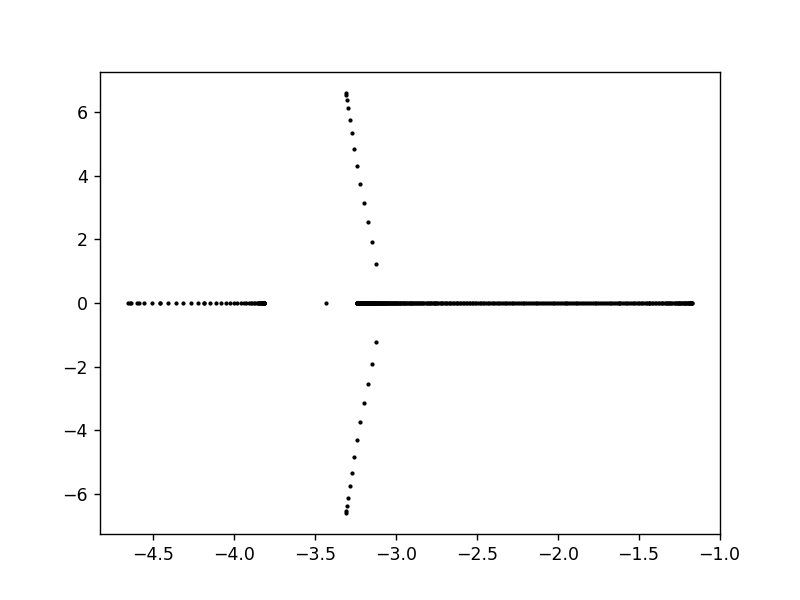

E*=0.0250, I*=0.1713: stable, with nonzero imaginary components


<IPython.core.display.Javascript object>


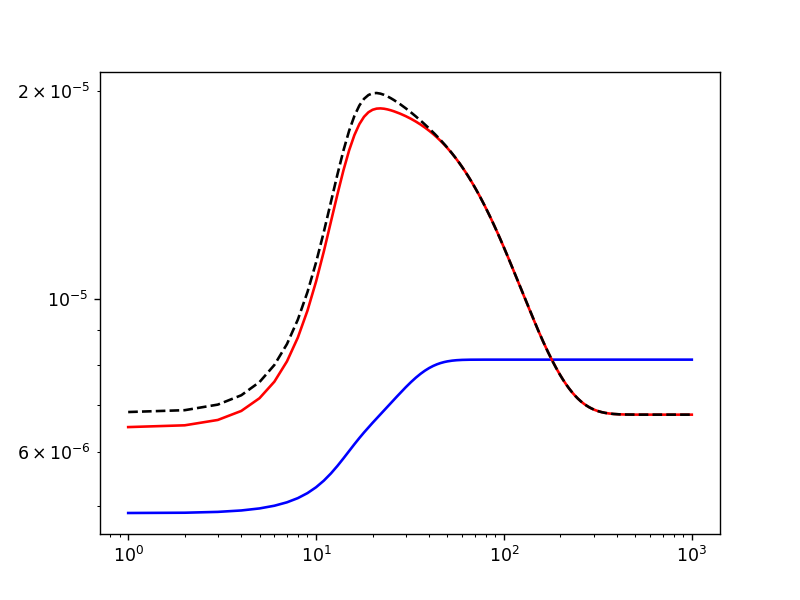

<IPython.core.display.Javascript object>


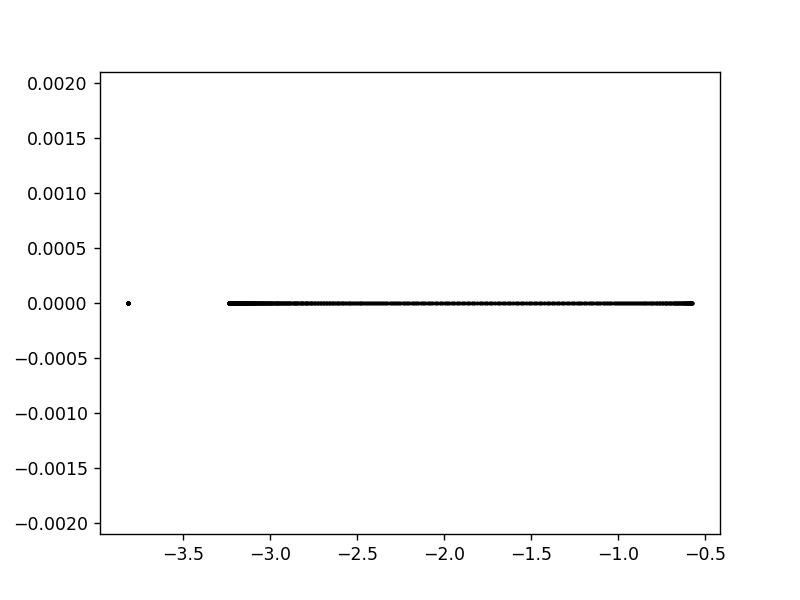

E*=0.1719, I*=0.2068: strictly stable


<IPython.core.display.Javascript object>


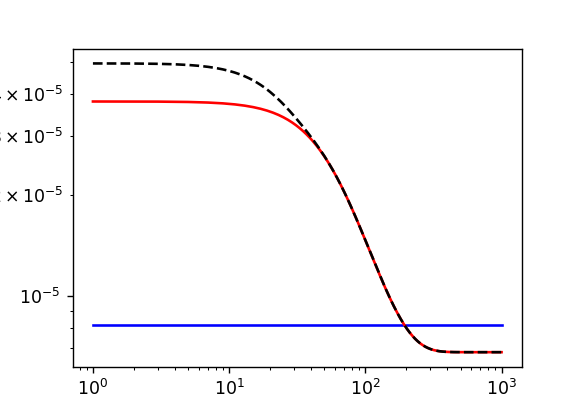

In [69]:
#TEST 1-2: STEADY STATES AND STABILITY VIA NUMERICAL SIMULATION
#set up 1D-specific simulation parameters and WCM propagators
one_dim=True
syn=0
gridsize=1000
h=1 
one_dim_eigenvalues = one_dim_Laplacian_eigenvalues(gridsize, h, syn)
#one_dim_eigenvalues2 = one_dim_Laplacian_eigenvalues(gridsize, h, syn)

#use these if simulating minimization results
aEE=better_result['x'][0]
aIE=better_result['x'][1]
aEI=better_result['x'][2]
aII=better_result['x'][3]
dE=better_result['x'][4]
dI=better_result['x'][5]
P=better_result['x'][6]
Q=better_result['x'][7]
sEE=better_result['x'][8]
sIE=better_result['x'][9]
sEI=better_result['x'][10]
sII=better_result['x'][11]
D=better_result['x'][12]
tE=better_result['x'][13]
tI=better_result['x'][14]
#snE=better_result['x'][15]
#snI=better_result['x'][16]

#given parameters, calculate steady states
steady_states, success = H_Simple_Steady_State(aEE, aIE, aEI, aII, dE, dI, P, Q)


#for each steady state, compute linear stability and power spectrum
if success==True:
    nrSS=len(steady_states[0])
    allG = np.empty((nrSS,gridsize,2,2), dtype=float)
    SStypes=np.zeros(nrSS)
    for ss in range(nrSS):

        Ess = steady_states[0,ss]
        Iss = steady_states[1,ss]

        SStypes[ss], found_suitable, JacEigs = GraphWC_Jacobian_TrDet(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                         alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
                                         tau_e=tE, tau_i=tI, Visual=True) 


        allG[ss,:,:,:] = Graph_WC_SpatialPowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
                                                 sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
                                                 tau_e=tE, tau_i=tI,
                                                 sigma_noise_e=0.01, sigma_noise_i=0.01, Visual=True)

<IPython.core.display.Javascript object>


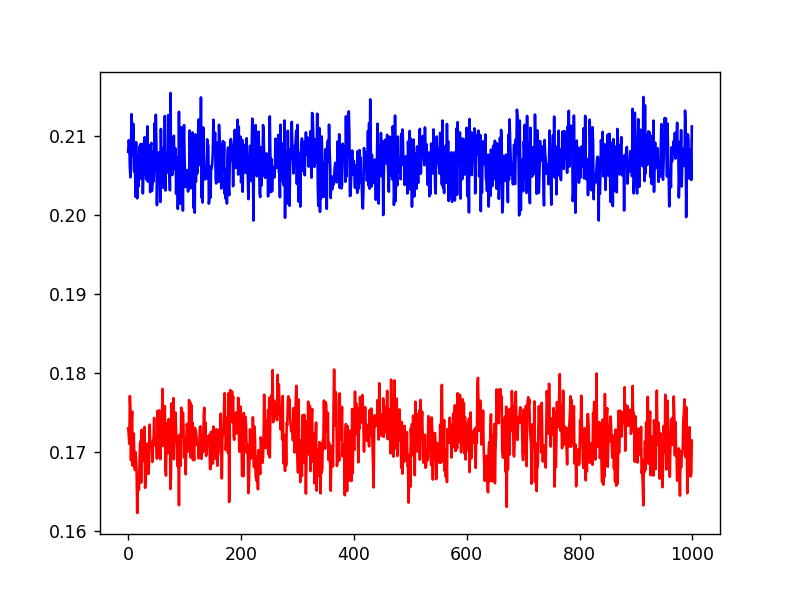

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

<IPython.core.display.Javascript object>


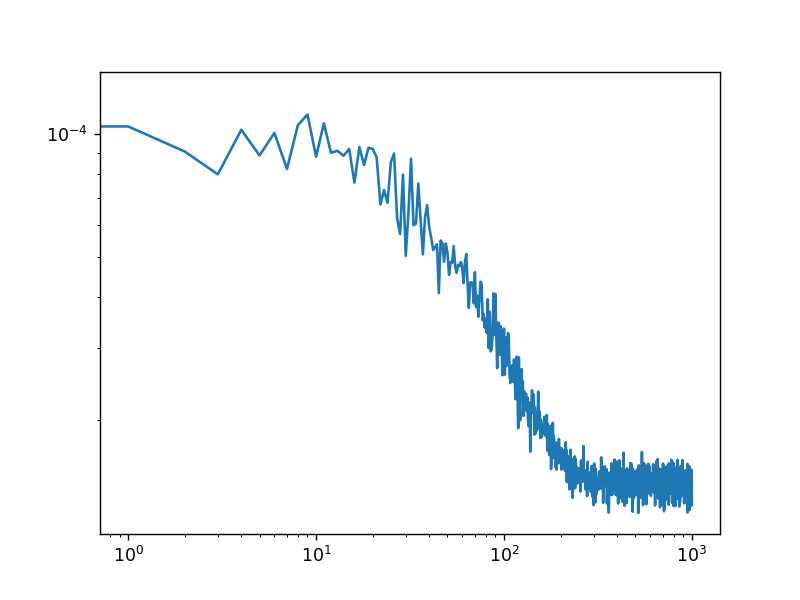

In [68]:
#Now, run a deterministic, 1D grid simulation to verify that steady states are correct
nrSS=2
gridsize=1000
Time=200
Delta_t=0.02
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    
E_0 = np.ones(gridsize)*Ess
I_0 = np.ones(gridsize)*Iss


steady_states
E_total= Graph_Wilson_Cowan_Model(E_0, I_0, Time, Delta_t,                          
                         aEE, aIE, aEI, aII, sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, sigma_noise_e=0.01, sigma_noise_i=0.01, 
                         Graph_Kernel='Gaussian', one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         eigvals=None, eigvecs=None,
                         Visual=True, SaveActivity=True, Filepath=' ')   

PS=Activity_Analysis(E_total, Ess, one_dim=True, syn=syn, gridsize=gridsize, h=h, eigvecs=None, Visual=True)
    

<IPython.core.display.Javascript object>


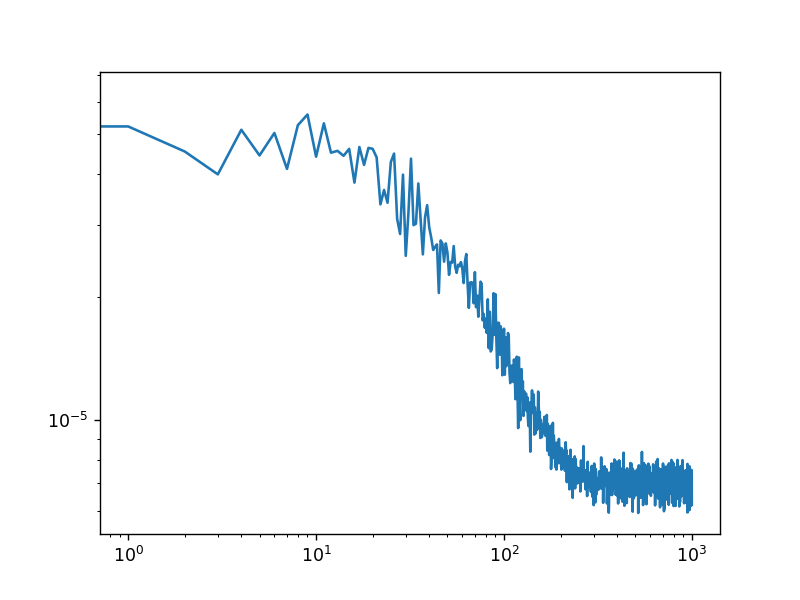

In [70]:
PS=Activity_Analysis(E_total, Ess, one_dim=True, syn=syn, gridsize=gridsize, h=h, eigvecs=None, Visual=True)


<IPython.core.display.Javascript object>


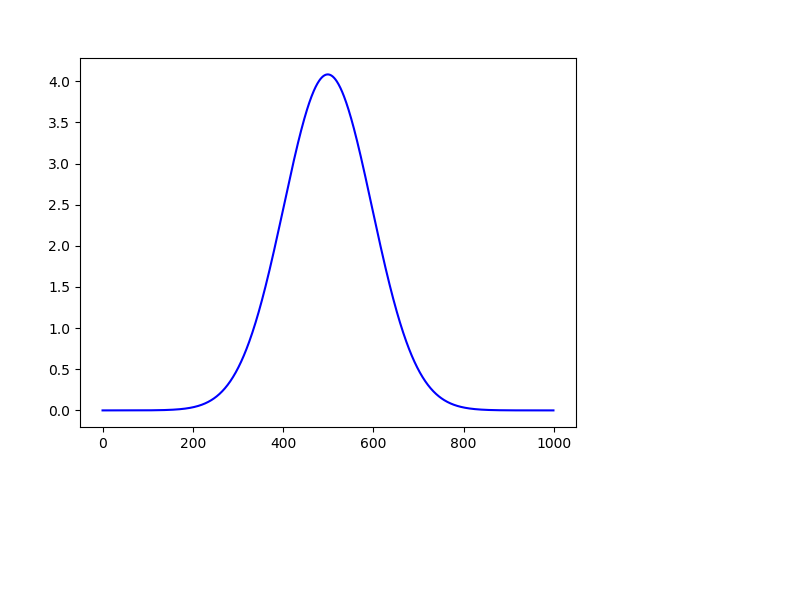

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

KeyboardInterrupt: 

In [31]:
u_0=np.zeros(1000)
Delta_t=0.01
Time=100
u_0[499]=1000
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=0.01, Graph_Kernel='Gaussian', sigma_noise=0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)